# Trend Detection

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
def load_model_and_predict(channel, features, model_folder='ML_Models'):
    # Check for NaN values in the features
    if features.isna().any().any():
        print(f"NaN detected in channel: {channel}")
        print("Columns with NaN values:")
        print(features.columns[features.isna().any()].tolist())
        print("Rows with NaN values:")
        print(features[features.isna().any(axis=1)])
        raise ValueError(f"NaN values found in the data for channel: {channel}.")
    
    model_path = f'{model_folder}/{channel}_final_model_base_post_v5.joblib'
    model = joblib.load(model_path)
    
    return model.predict_proba(features)[:, 1]  

## Preparing Data

In [4]:
dir_names = [
    '1712094934_Nhan', 
    '1713985211_Mallory', 
    '1713999445_Wil', 
    '1713293584_Jacob', 
    '1713550894_AlexKagoda', 
    '1713820773_Andrew', 
    '1713994149_Saad', 
    '1713458084_Andrei', 
    '1714511822_Nathan'
]

stim = {'1712094934_Nhan': {'START1': 152682, 'ONSET1': None, 'END1': 185144, 'START2': 337670, 'ONSET2': 353901+30*250, 'END2': 370132, 'START3': 522856, 'ONSET3': 539087+20*250, 'END3': 555318, 'START4': 858098, 'ONSET4': 874329, 'END4': 890560}, '1713985211_Mallory': {'START1': 152519-10*250, 'ONSET1': 155041, 'END1': 184947, 'START2': 337496, 'ONSET2': 341941, 'END2': 370003, 'START3': 521934-30*250, 'ONSET3': 527943, 'END3': 542732, 'START4': 701929-20*250, 'ONSET4': 703008, 'END4': 733549-10*250}, '1713999445_Wil': {'START1': 152704, 'ONSET1': None, 'END1': 185166, 'START2': 337858, 'ONSET2': 350239, 'END2': 370200, 'START3': 522909, 'ONSET3': 531924, 'END3': 555391, 'START4': 725204, 'ONSET4': 729048, 'END4': 757546}, '1713293584_Jacob': {'START1': 152521, 'ONSET1': 155644, 'END1': 184983, 'START2': 337581, 'ONSET2': 339141, 'END2': 369910, 'START3': 522521, 'ONSET3': 527568, 'END3': 555009, 'START4': 740316, 'ONSET4': 741996, 'END4': 772658}, '1713550894_AlexKagoda': {'START1': 152680, 'ONSET1': None, 'END1': 185142, 'START2': 337726, 'ONSET2': 362372, 'END2': 370130, 'START3': 522701, 'ONSET3': 534883, 'END3': 555204, 'START4': 741344, 'ONSET4': 766952, 'END4': 773685}, '1713820773_Andrew': {'START1': 152635, 'ONSET1': None, 'END1': 185097, 'START2': 337767, 'ONSET2': None, 'END2': 370075, 'START3': 522695, 'ONSET3': 535677, 'END3': 555036, 'START4': 706607, 'ONSET4': 715261, 'END4': 739087}, '1713994149_Saad': {'START1': 152584, 'ONSET1': 156068, 'END1': 185037, 'START2': 304073, 'ONSET2': 317056, 'END2': 336501, 'START3': 489085, 'ONSET3': 509282, 'END3': 521547, 'START4': 651886, 'ONSET4': 668117, 'END4': 684348}, '1713458084_Andrei': {'START1': 167500, 'ONSET1': 236174, 'END1': 237500, 'START2': 420000, 'ONSET2': 432172, 'END2': 460000, 'START3': 627500, 'ONSET3': 633382, 'END3': 660500, 'START4': 848500, 'ONSET4': 853409, 'END4': 880000}, '1714511822_Nathan': {'START1': 152704, 'ONSET1': 164364, 'END1': 185166, 'START2': 316708-10*250, 'ONSET2': 326685, 'END2': 349046, 'START3': 423713, 'ONSET3': 428880, 'END3': 456175, 'START4': 539620, 'ONSET4': 552362, 'END4': 572082}}
drop_columns = ['Index', 'C4_hjorthMobility', 'C4_hjorthComplexity', 'EDA-Skew', 'EDA-Kurt']

combined_X = pd.DataFrame()
combined_metadata = pd.DataFrame() 
new_classes = {
    '2 levels': {
        'order': {0: 0, 1: 1}, 
        'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1, 3)}
    }
}

for dir_name in dir_names:
    df = pd.read_csv(f'data/logging/{dir_name}/whole_dataset.csv')
    X_temp = df.drop(drop_columns, axis=1)
    
    metadata_temp = pd.DataFrame({
        'Dataset': [dir_name] * len(X_temp),
        'Original_Index': range(len(X_temp))
    })
    
    combined_X = pd.concat([combined_X, X_temp], axis=0, ignore_index=True)
    combined_metadata = pd.concat([combined_metadata, metadata_temp], axis=0, ignore_index=True)

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(combined_X)
combined_X = pd.DataFrame(X_normalized, columns=combined_X.columns)
combined_metadata = combined_metadata.reset_index(drop=True)

channels = {
    'O1': [col for col in combined_X.columns if 'O1' in col],
    'O2': [col for col in combined_X.columns if 'O2' in col],
    'C3': [col for col in combined_X.columns if 'C3' in col],
    'C4': [col for col in combined_X.columns if 'C4' in col],
    'EOG': [col for col in combined_X.columns if 'EOG' in col],
    'ECG': ['HR', 'HRV'],
    'EDA': [col for col in combined_X.columns if 'EDA' in col]
}

# Load models and predict for the probability curve

In [5]:
# Group the features by channels
grouped_features = {channel: combined_X[features] for channel, features in channels.items()}
final_probabilities = np.zeros(len(combined_X))

for channel, features in grouped_features.items():
    print(f"Processing channel: {channel}")
    channel_probs = load_model_and_predict(channel, features)
    final_probabilities += channel_probs

final_probabilities /= len(grouped_features)


Processing channel: O1
Processing channel: O2
Processing channel: C3
Processing channel: C4
Processing channel: EOG
Processing channel: ECG
Processing channel: EDA


## Onset detection

### Rising edge detection using regresion

Process 1712094934_Nhan


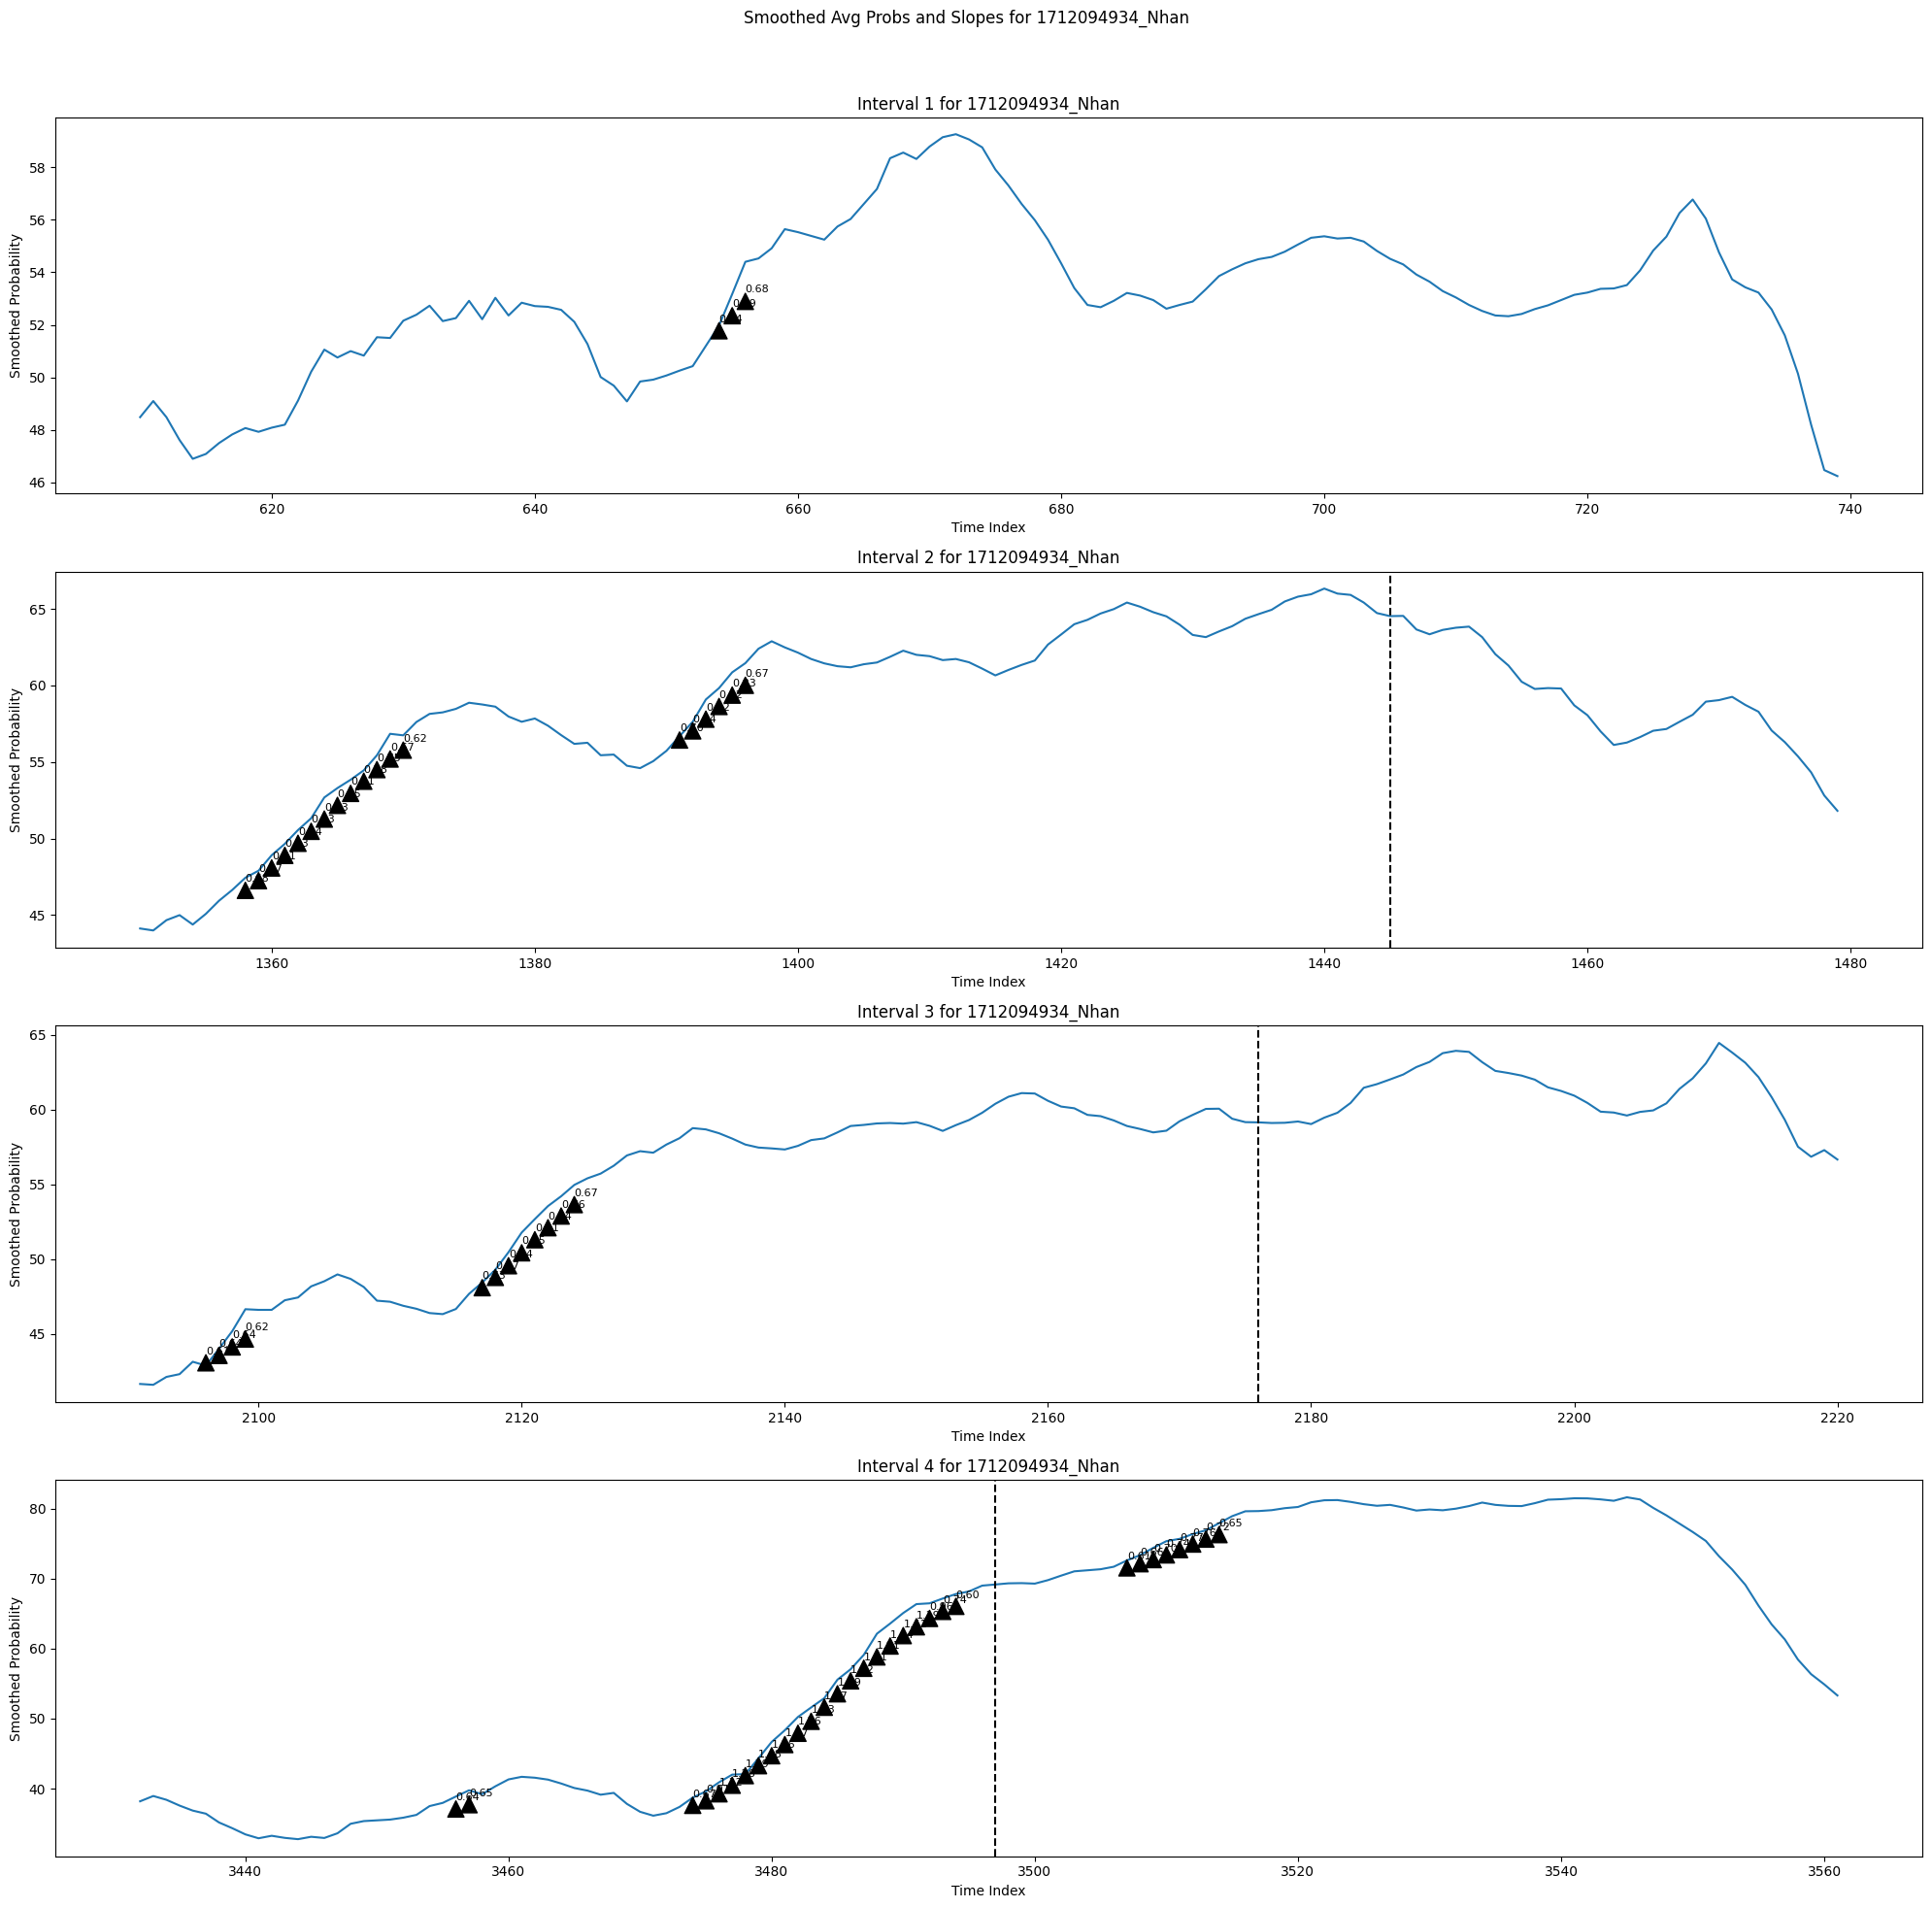

Process 1713985211_Mallory


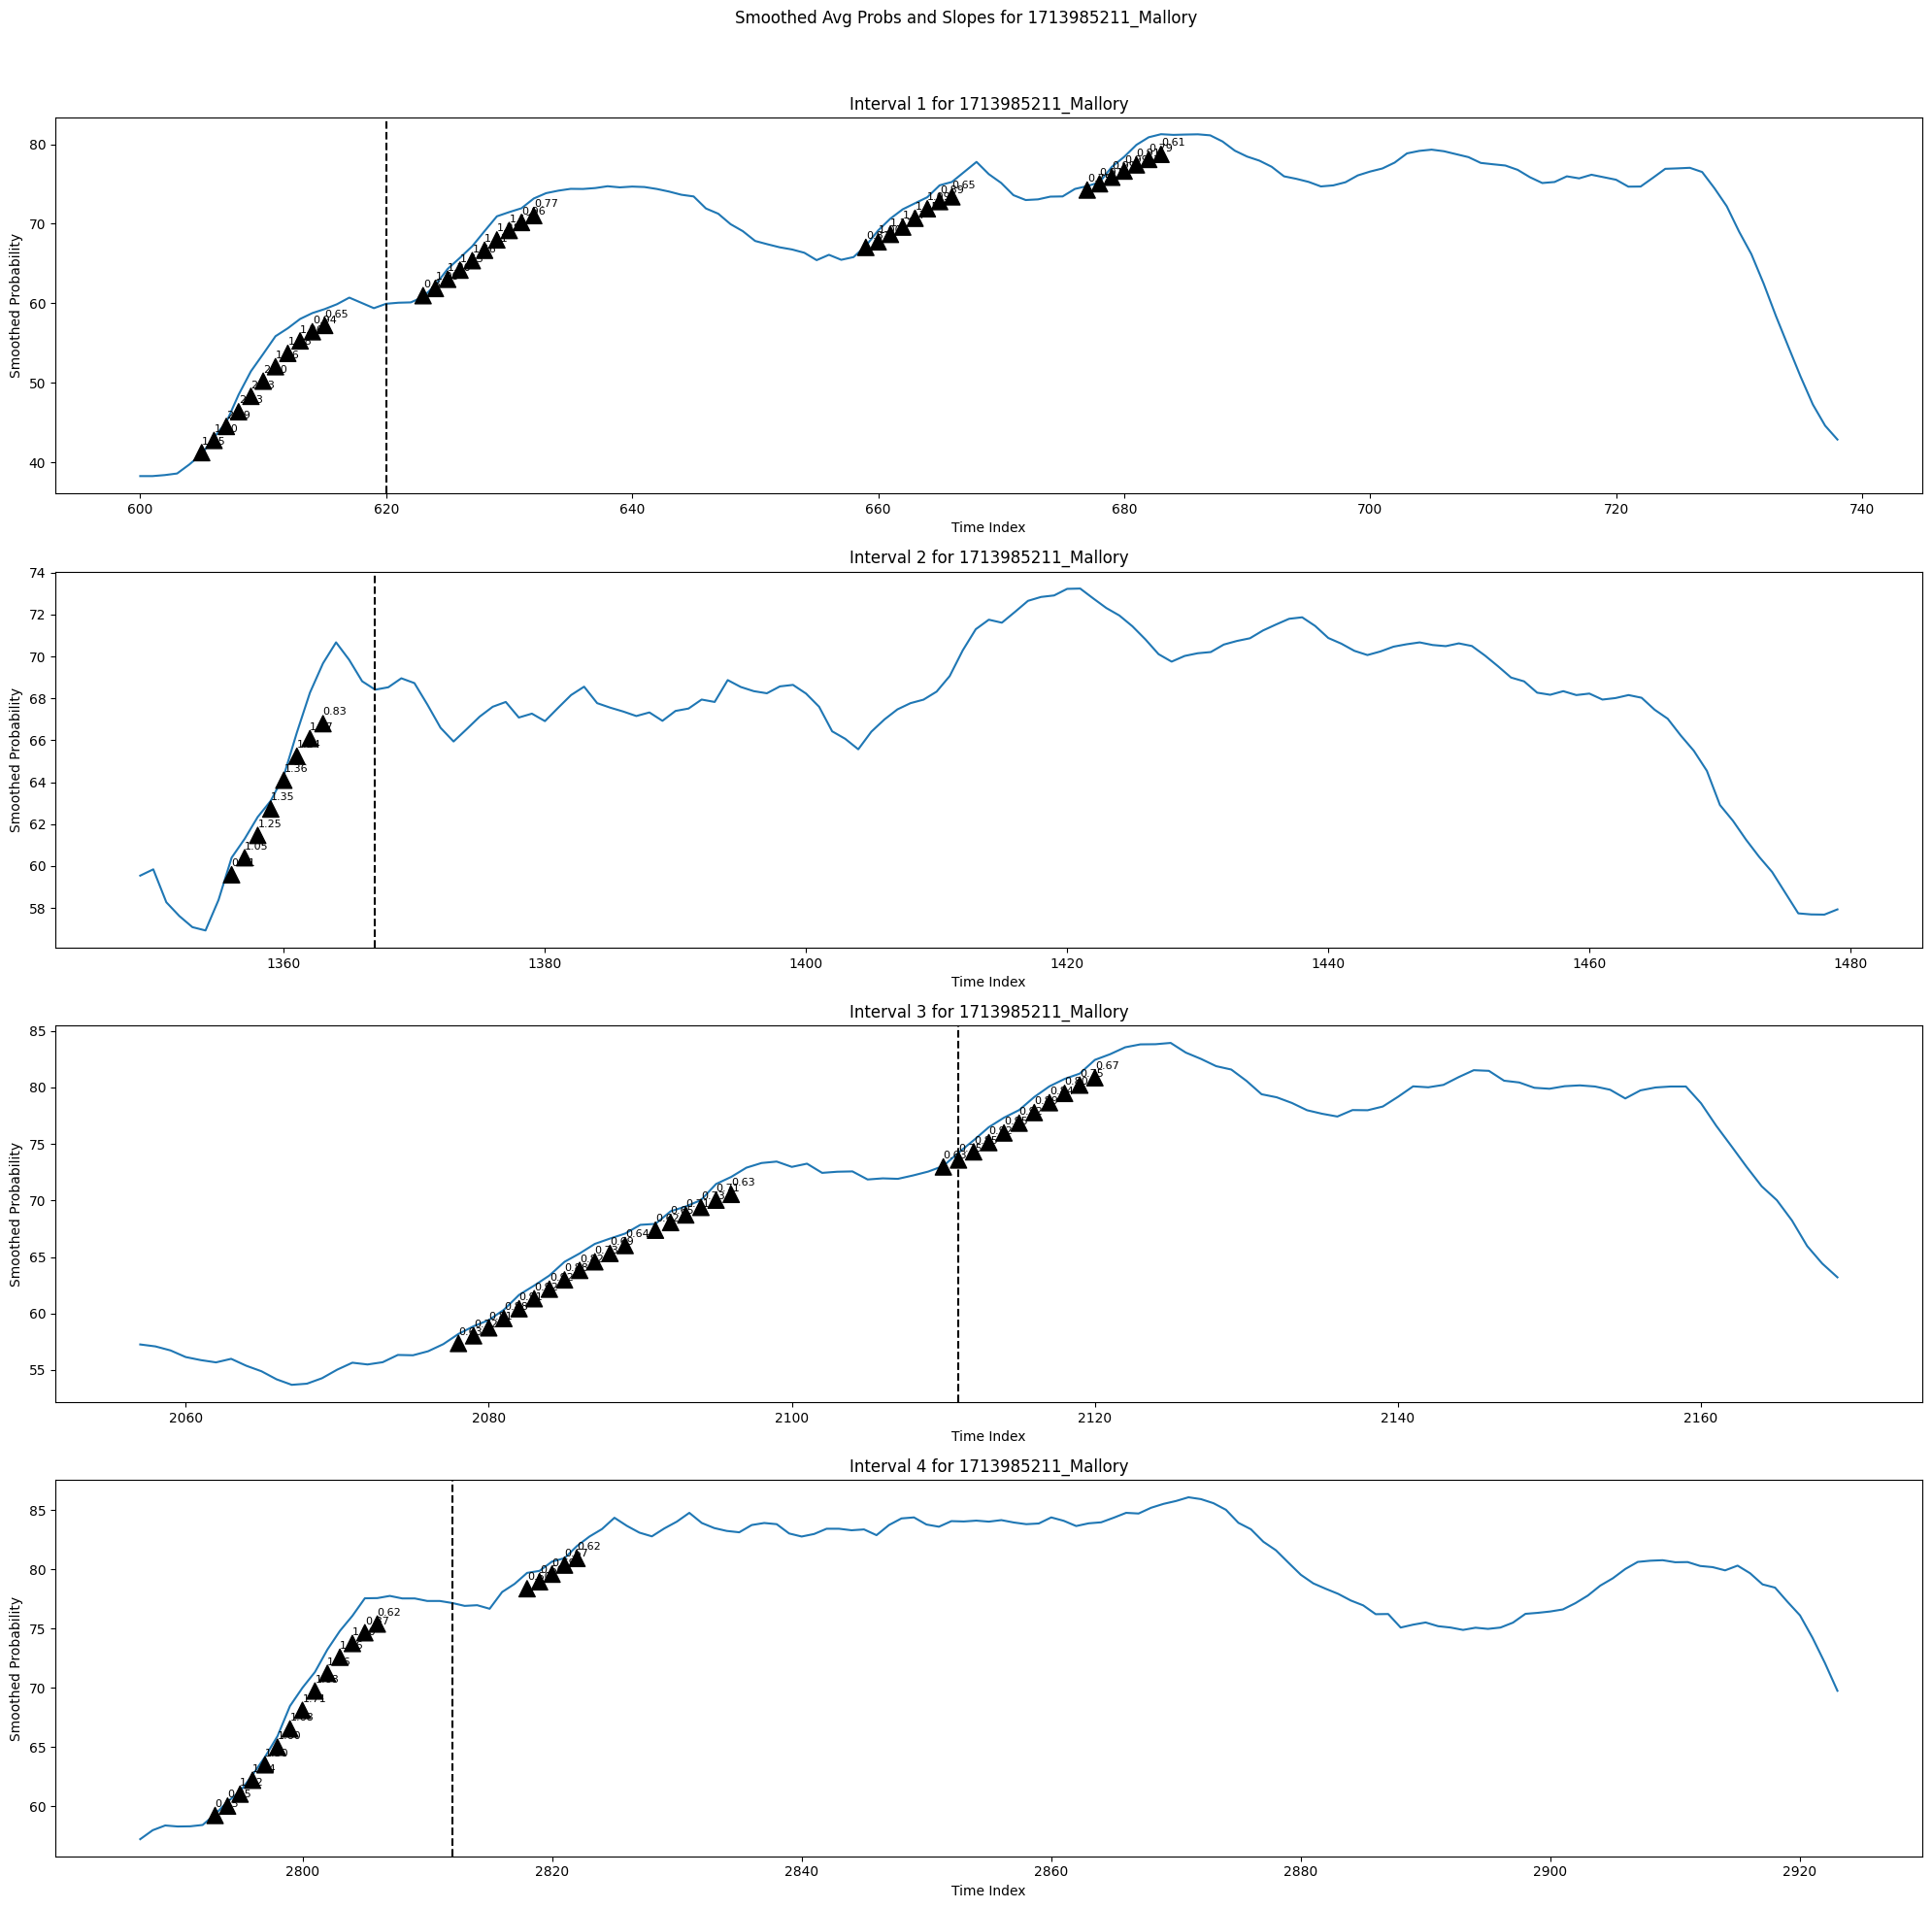

Process 1713999445_Wil


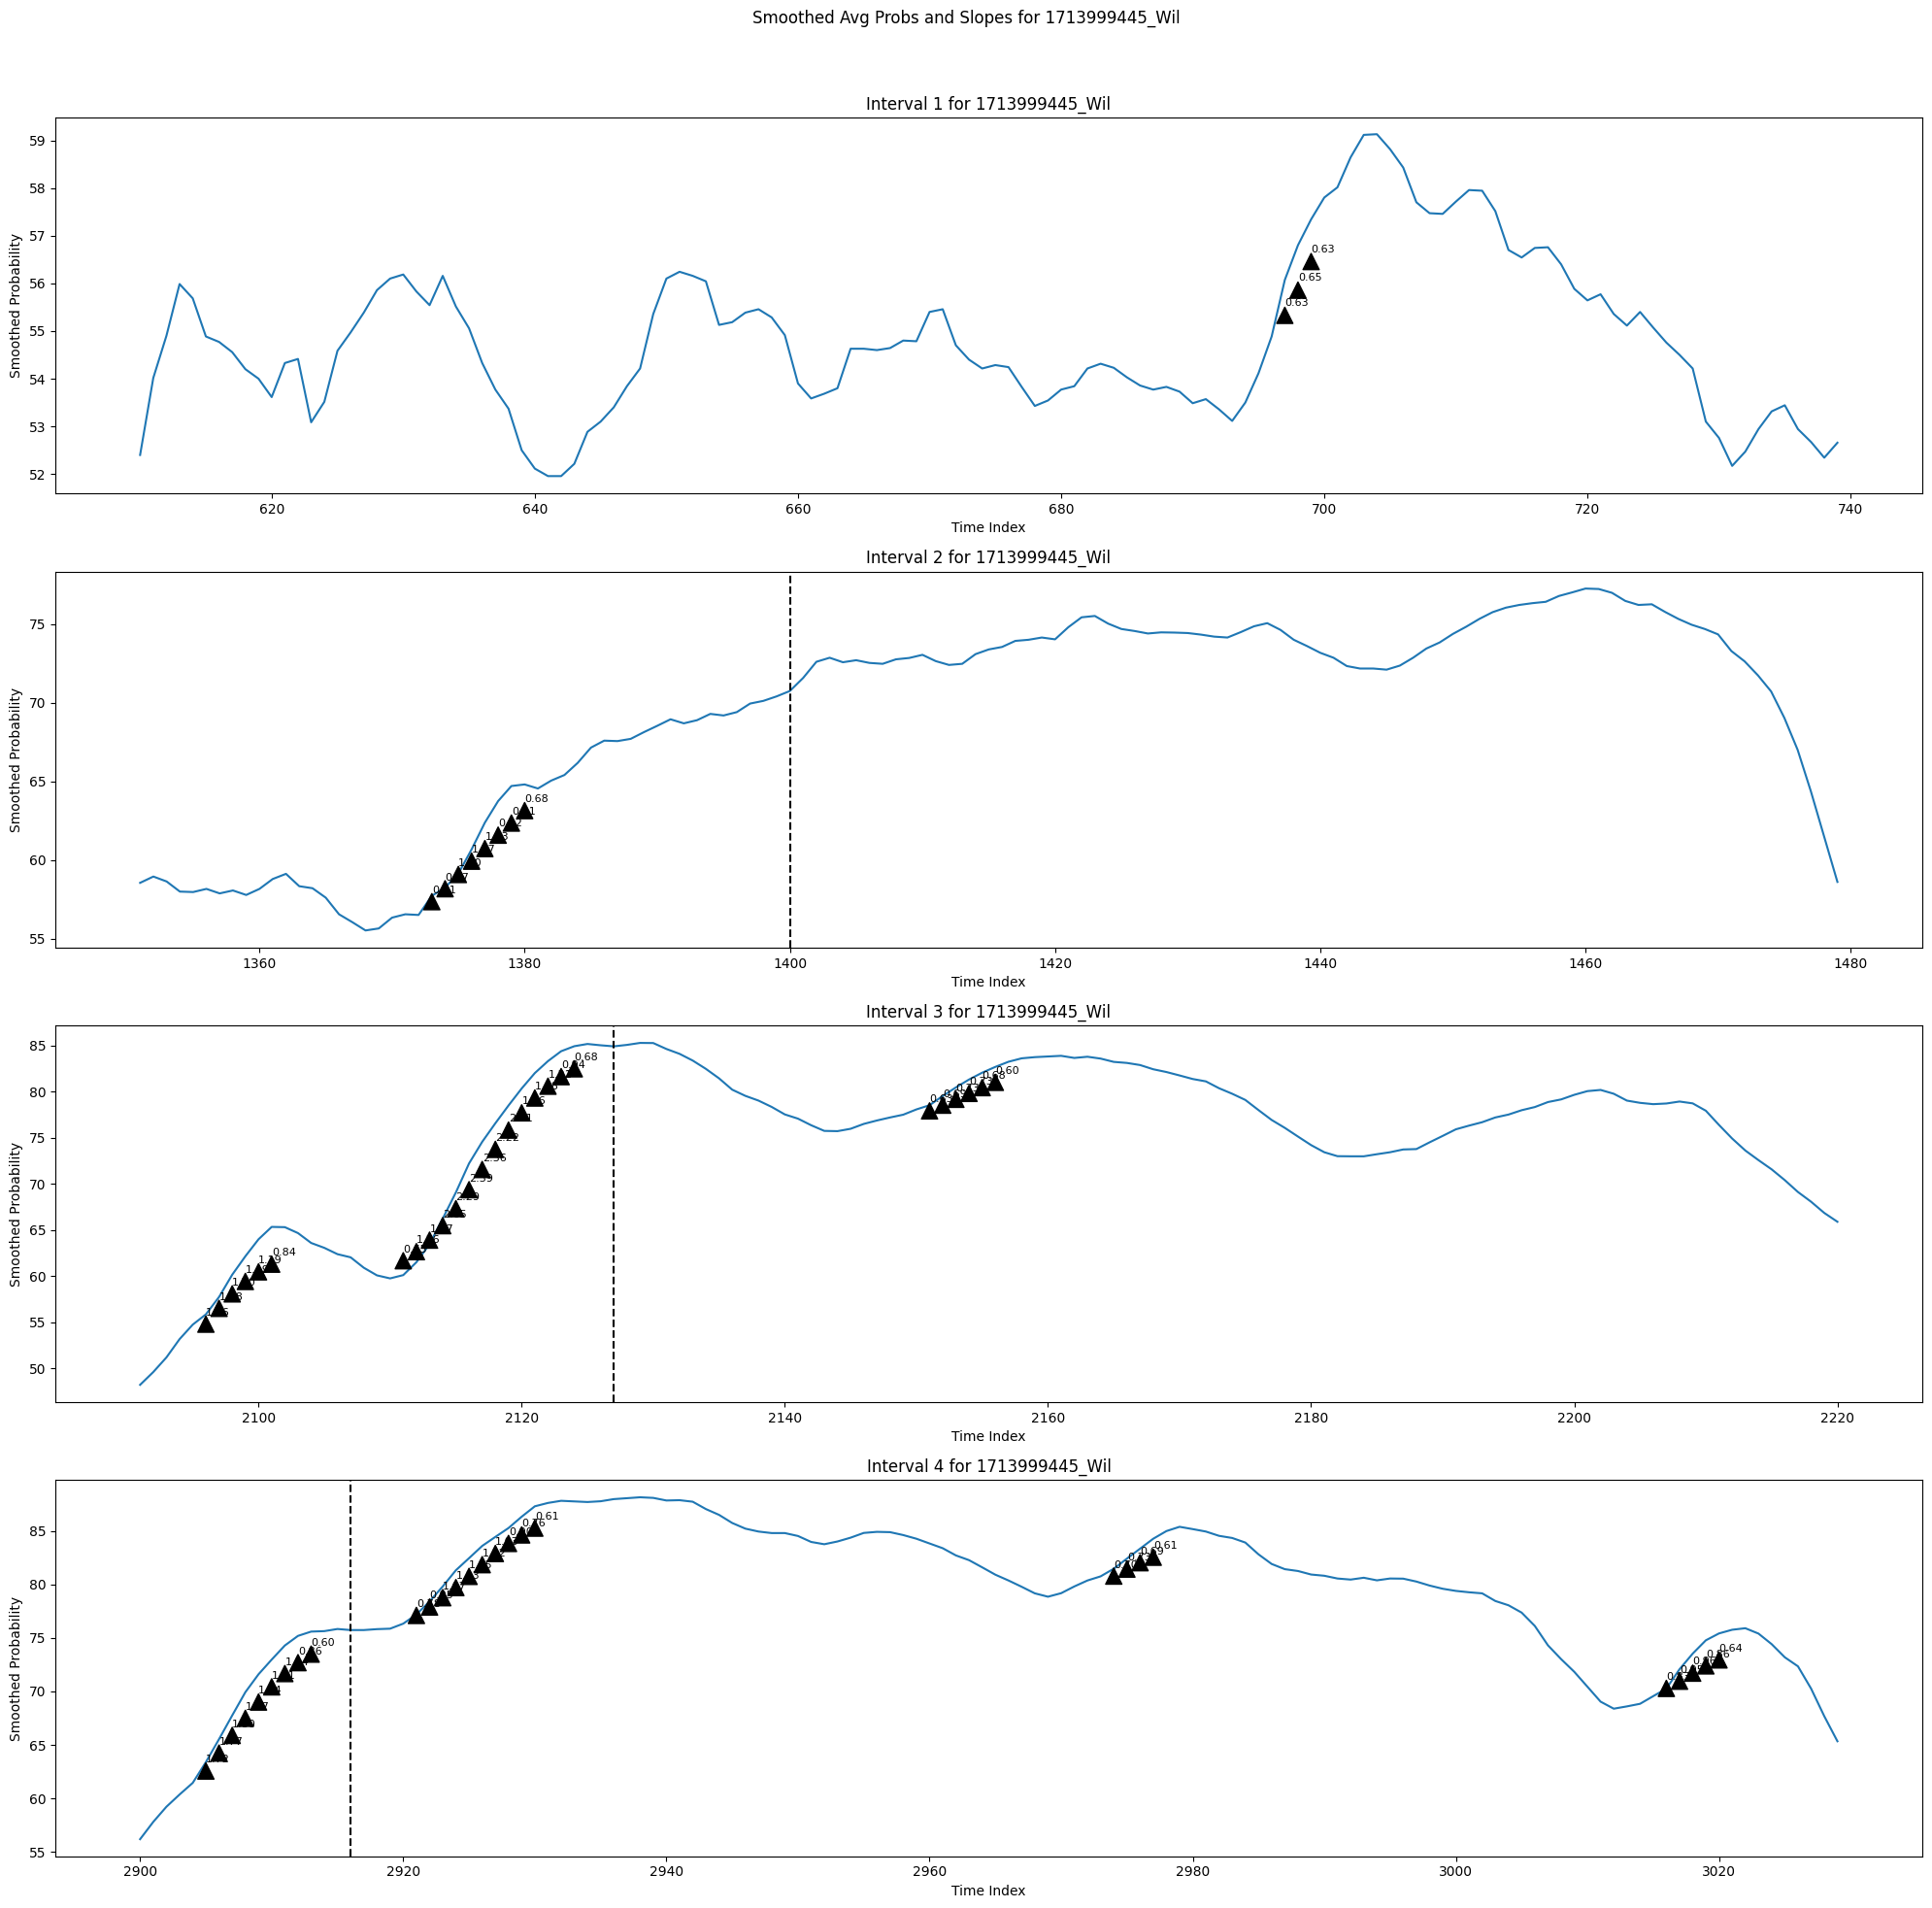

Process 1713293584_Jacob


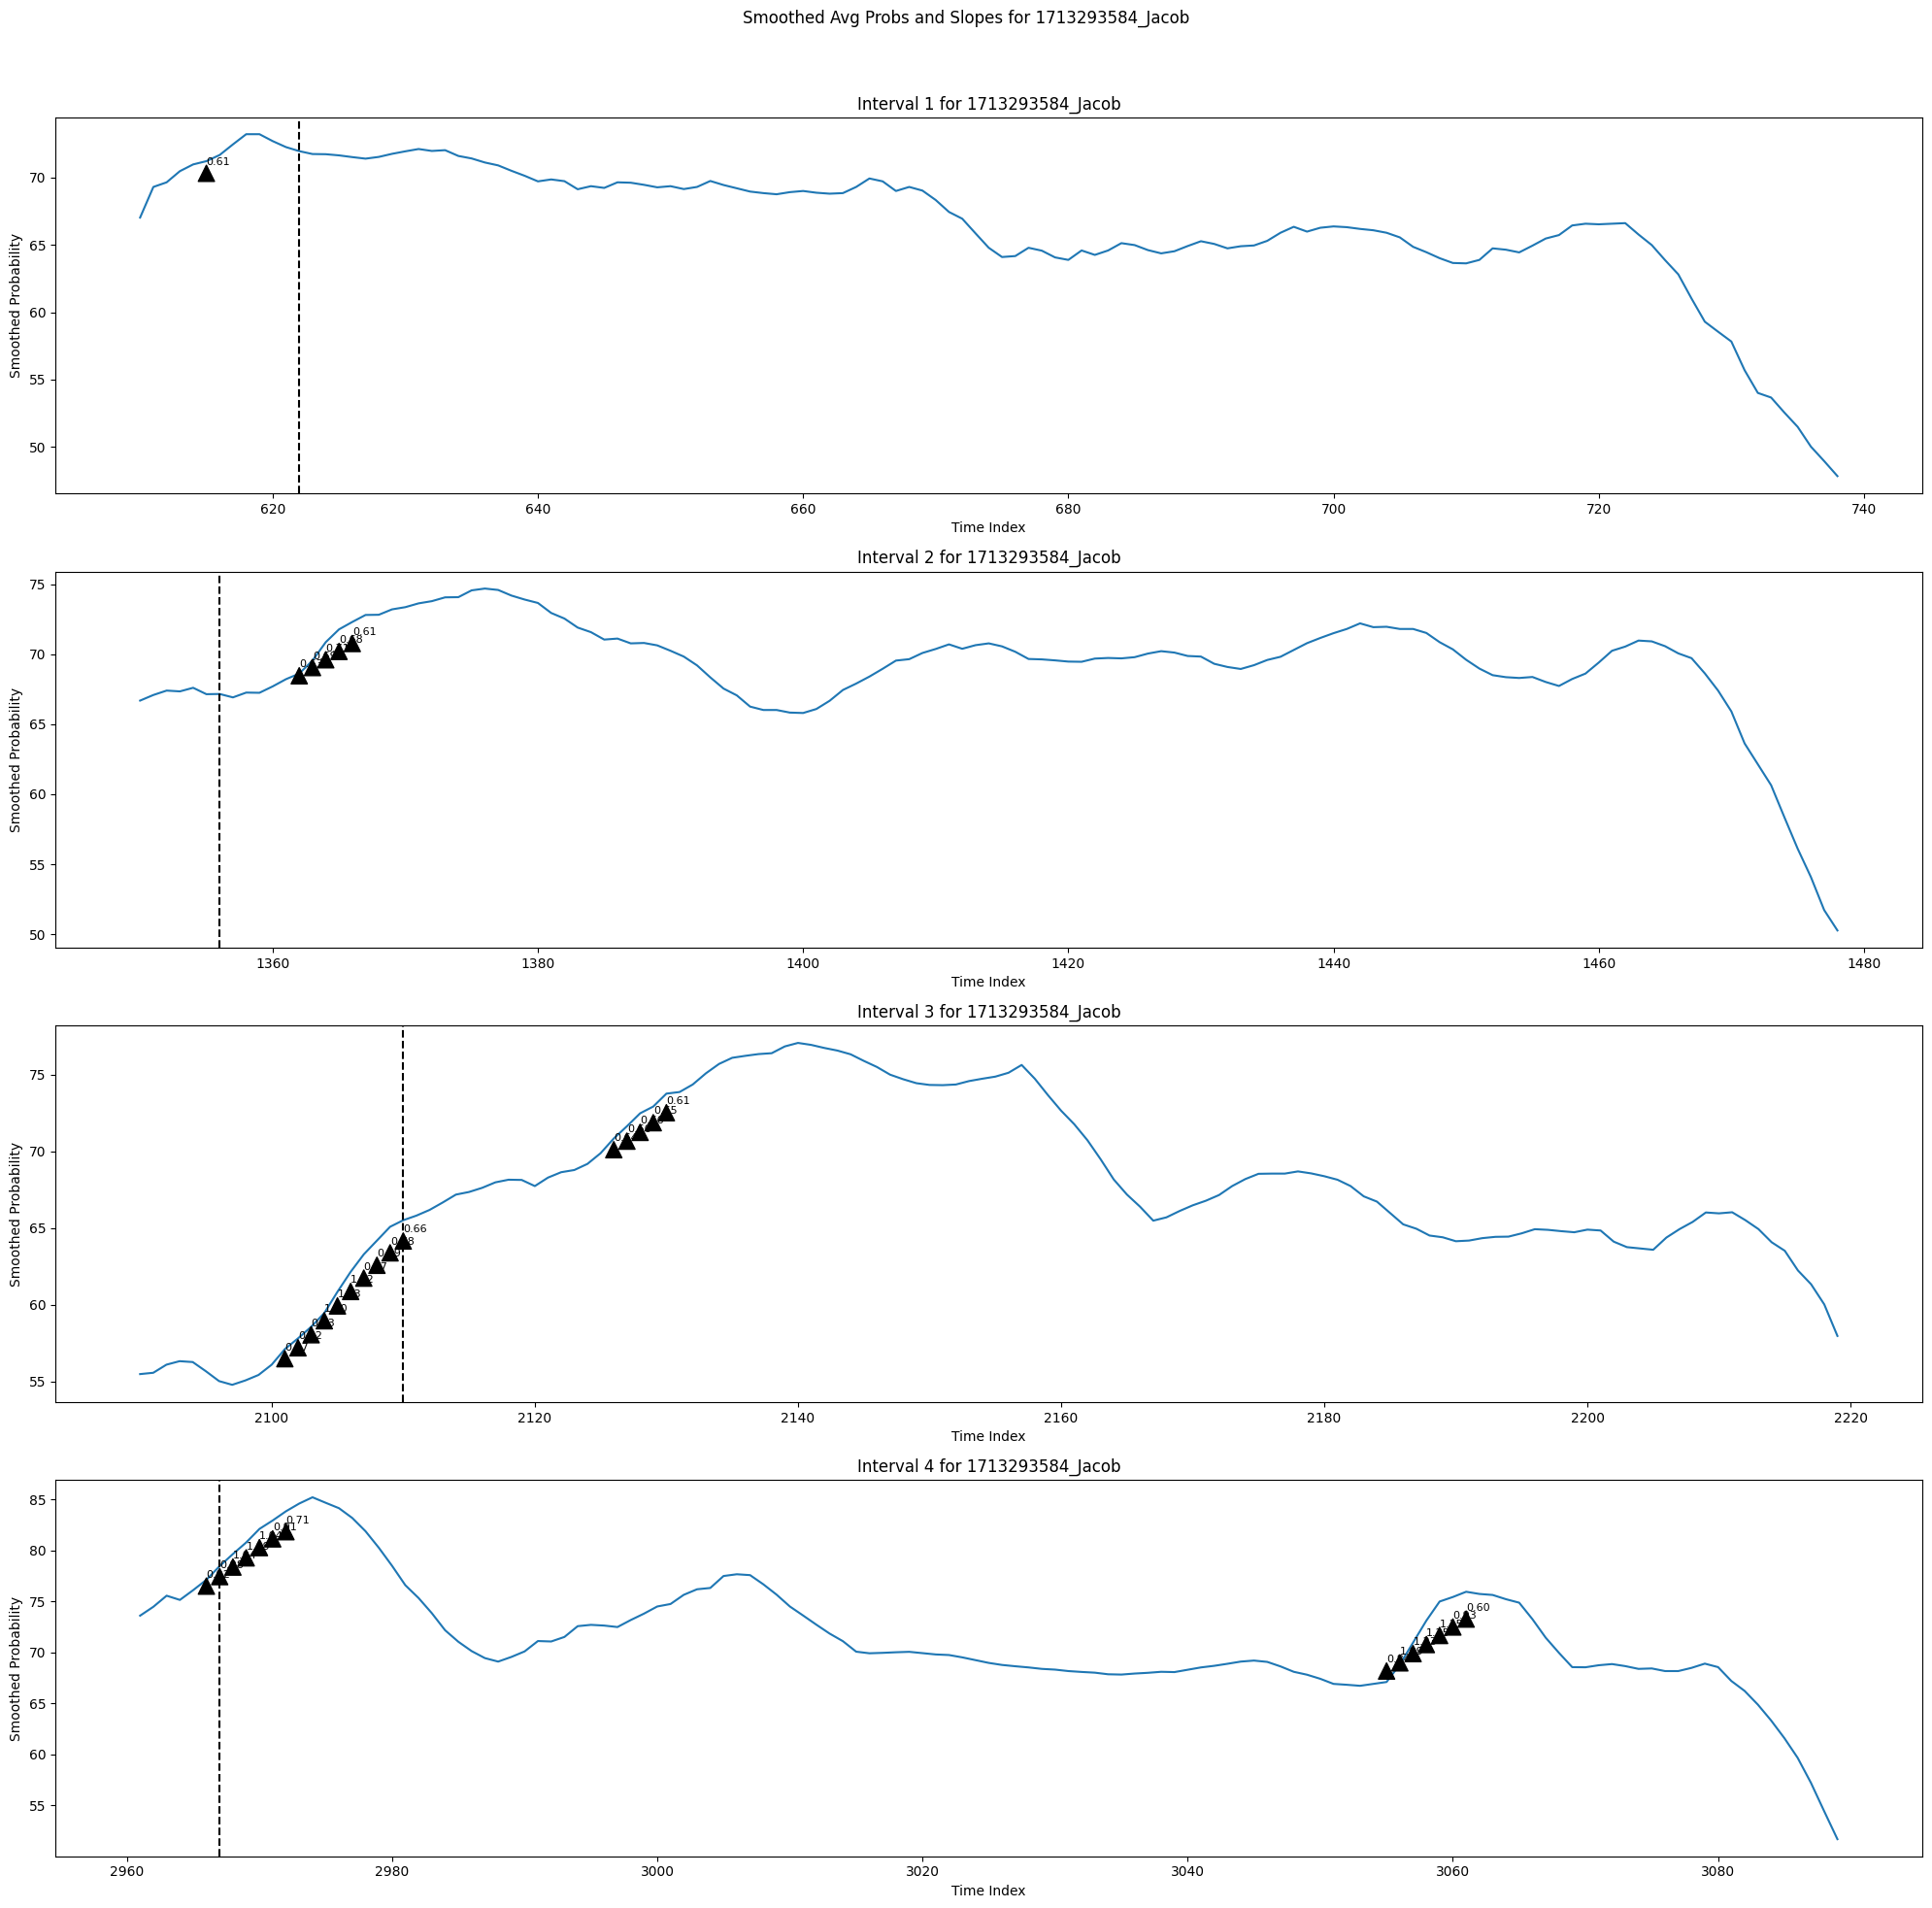

Process 1713550894_AlexKagoda


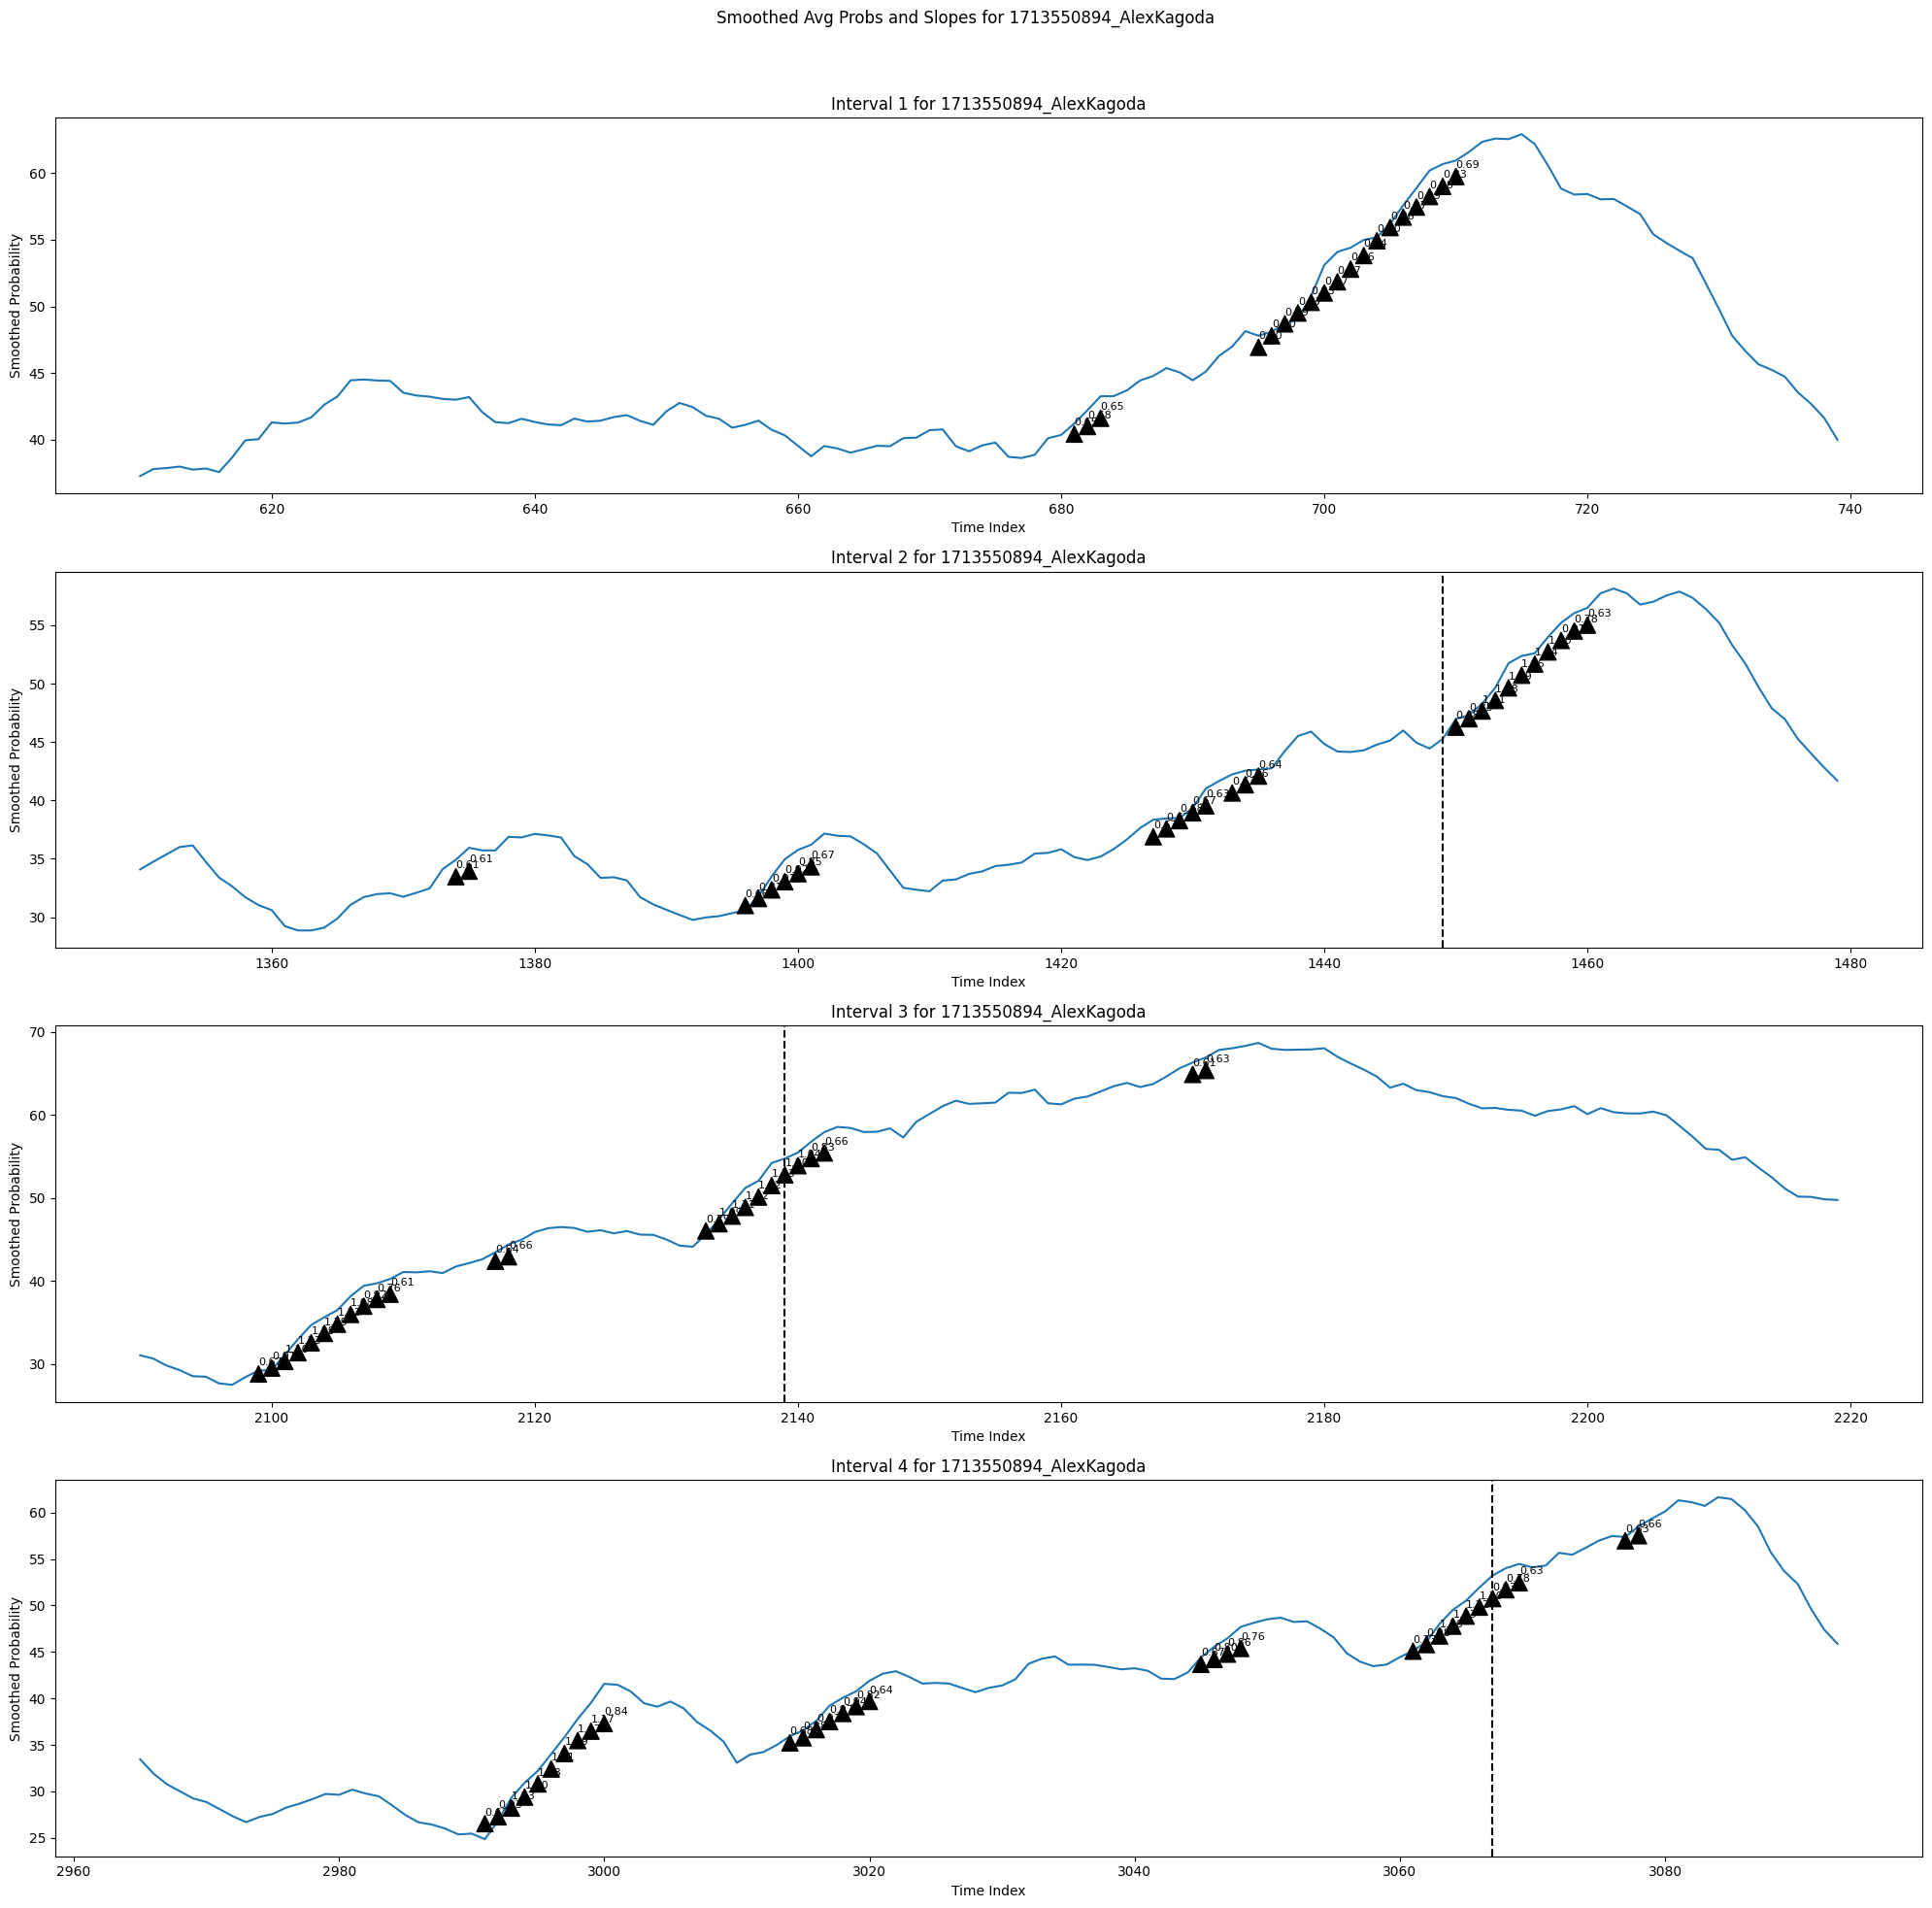

Process 1713820773_Andrew


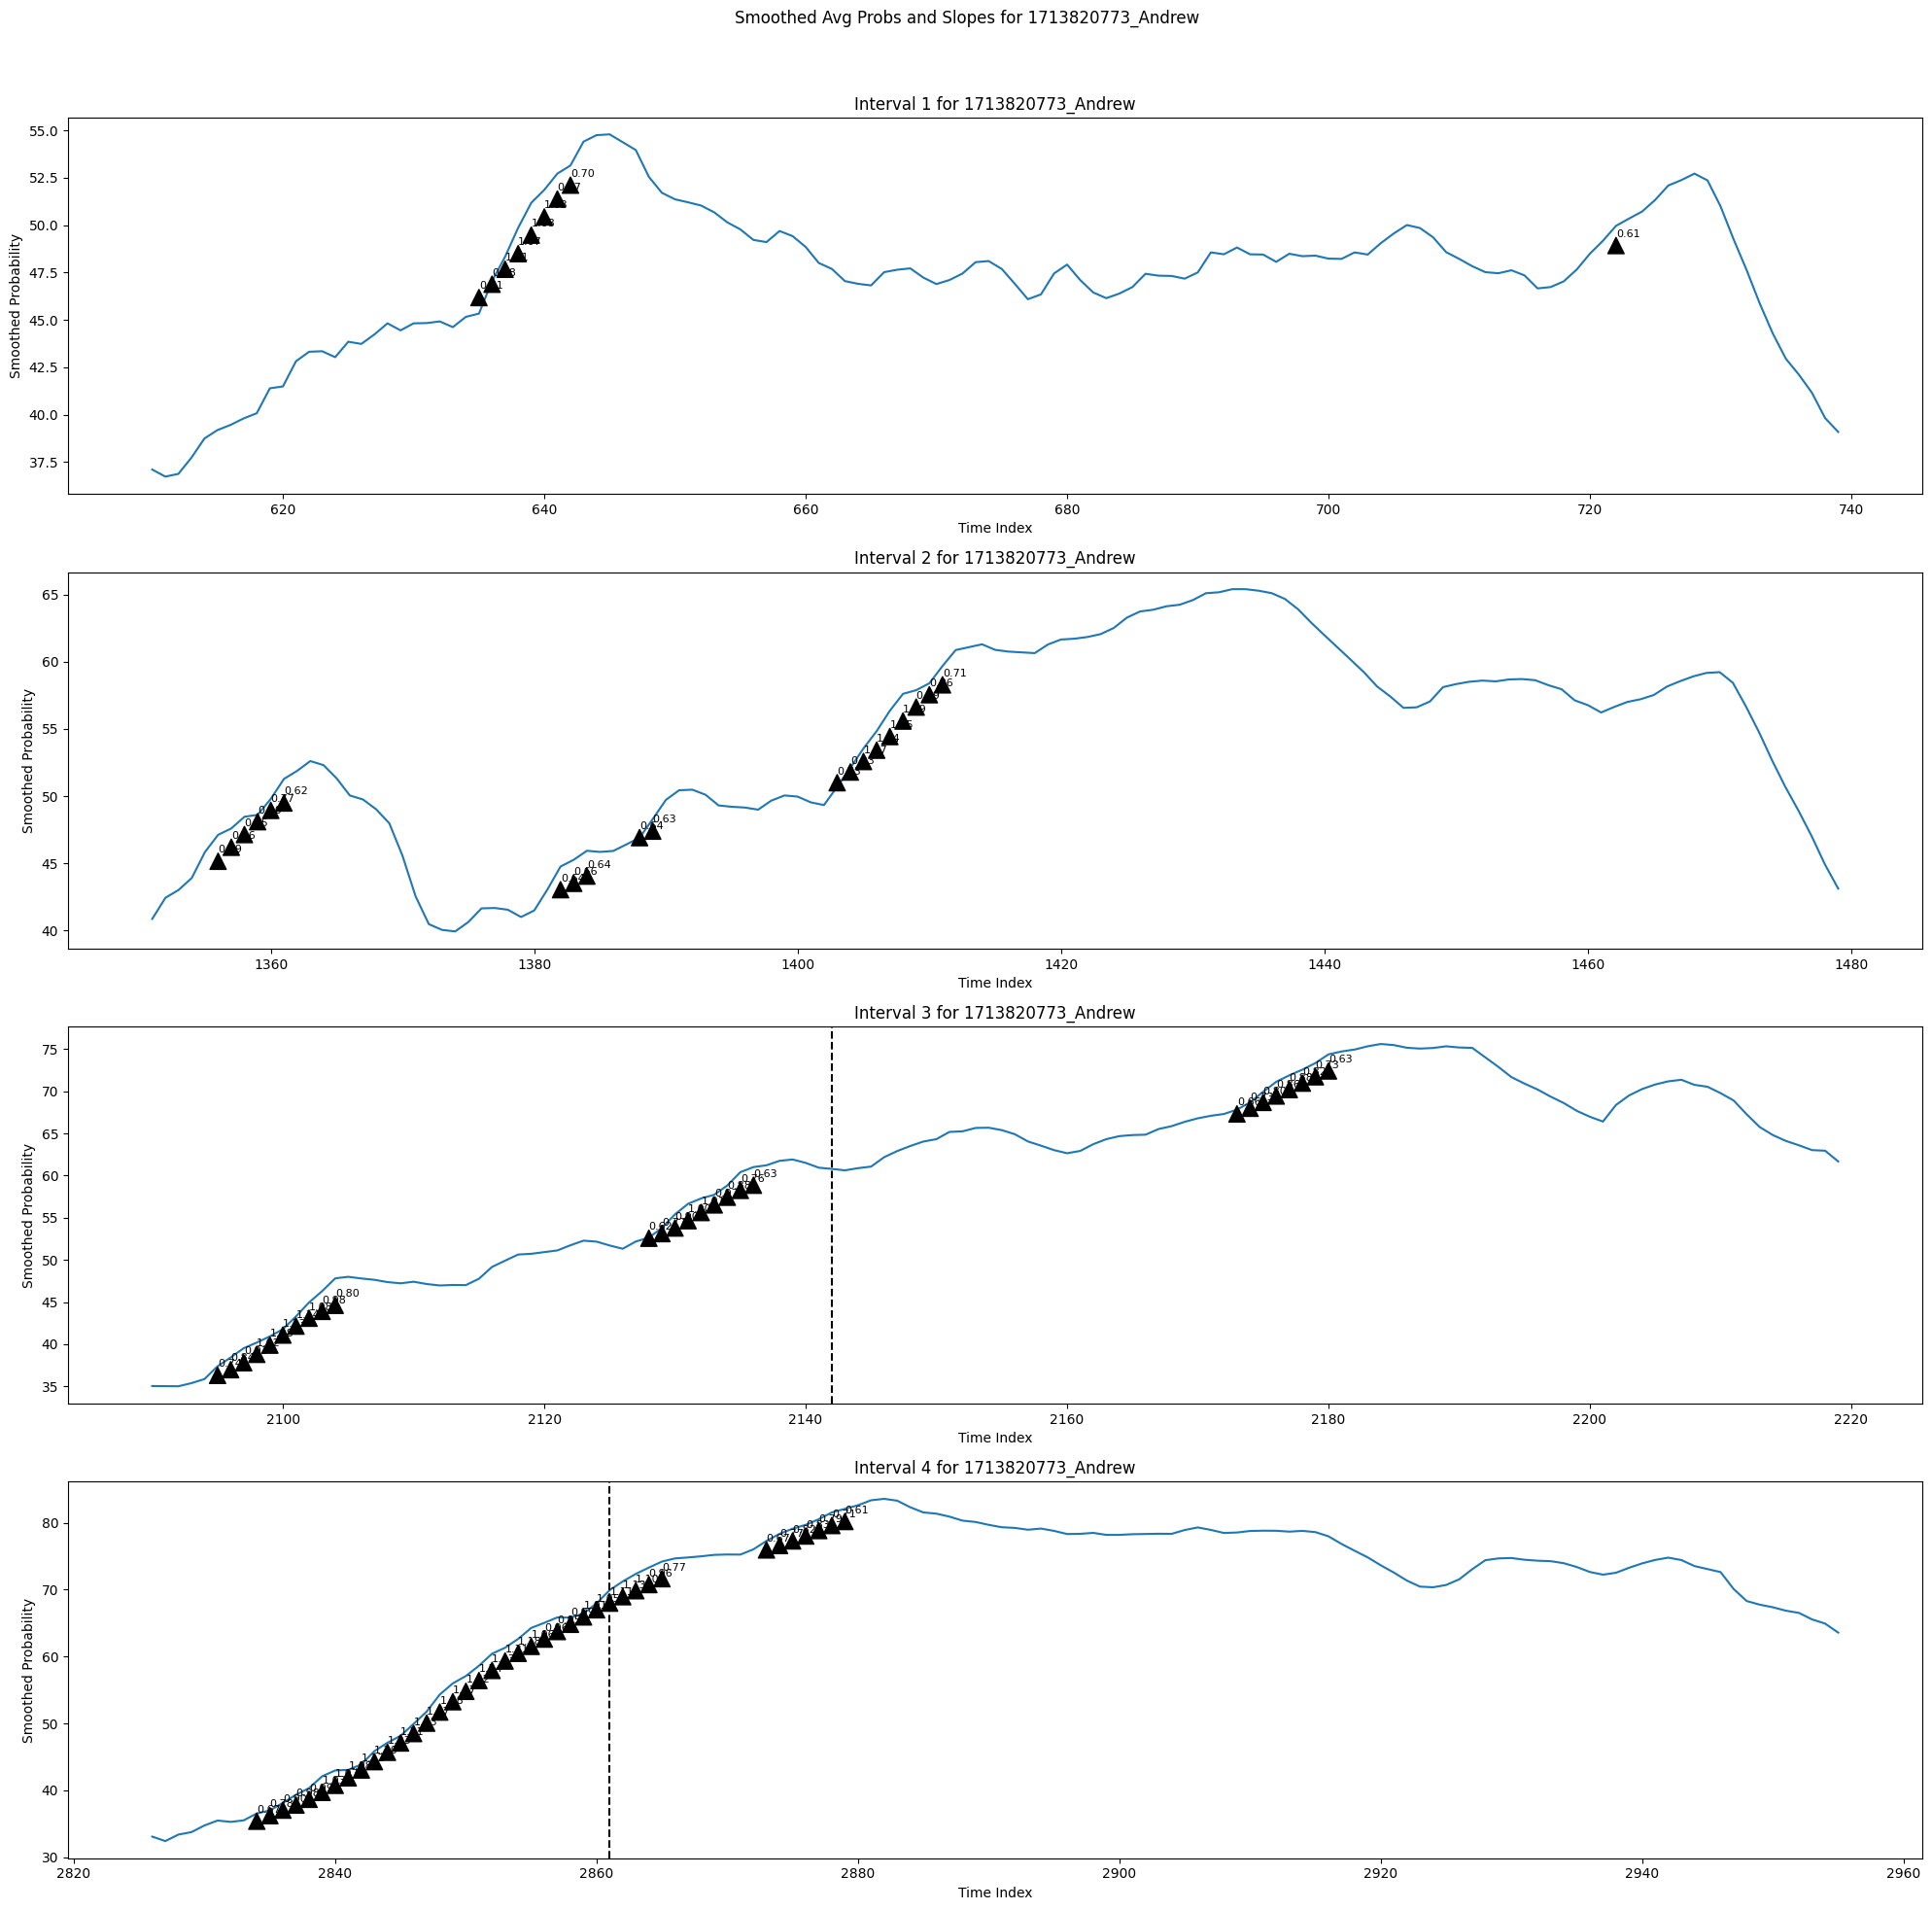

Process 1713994149_Saad


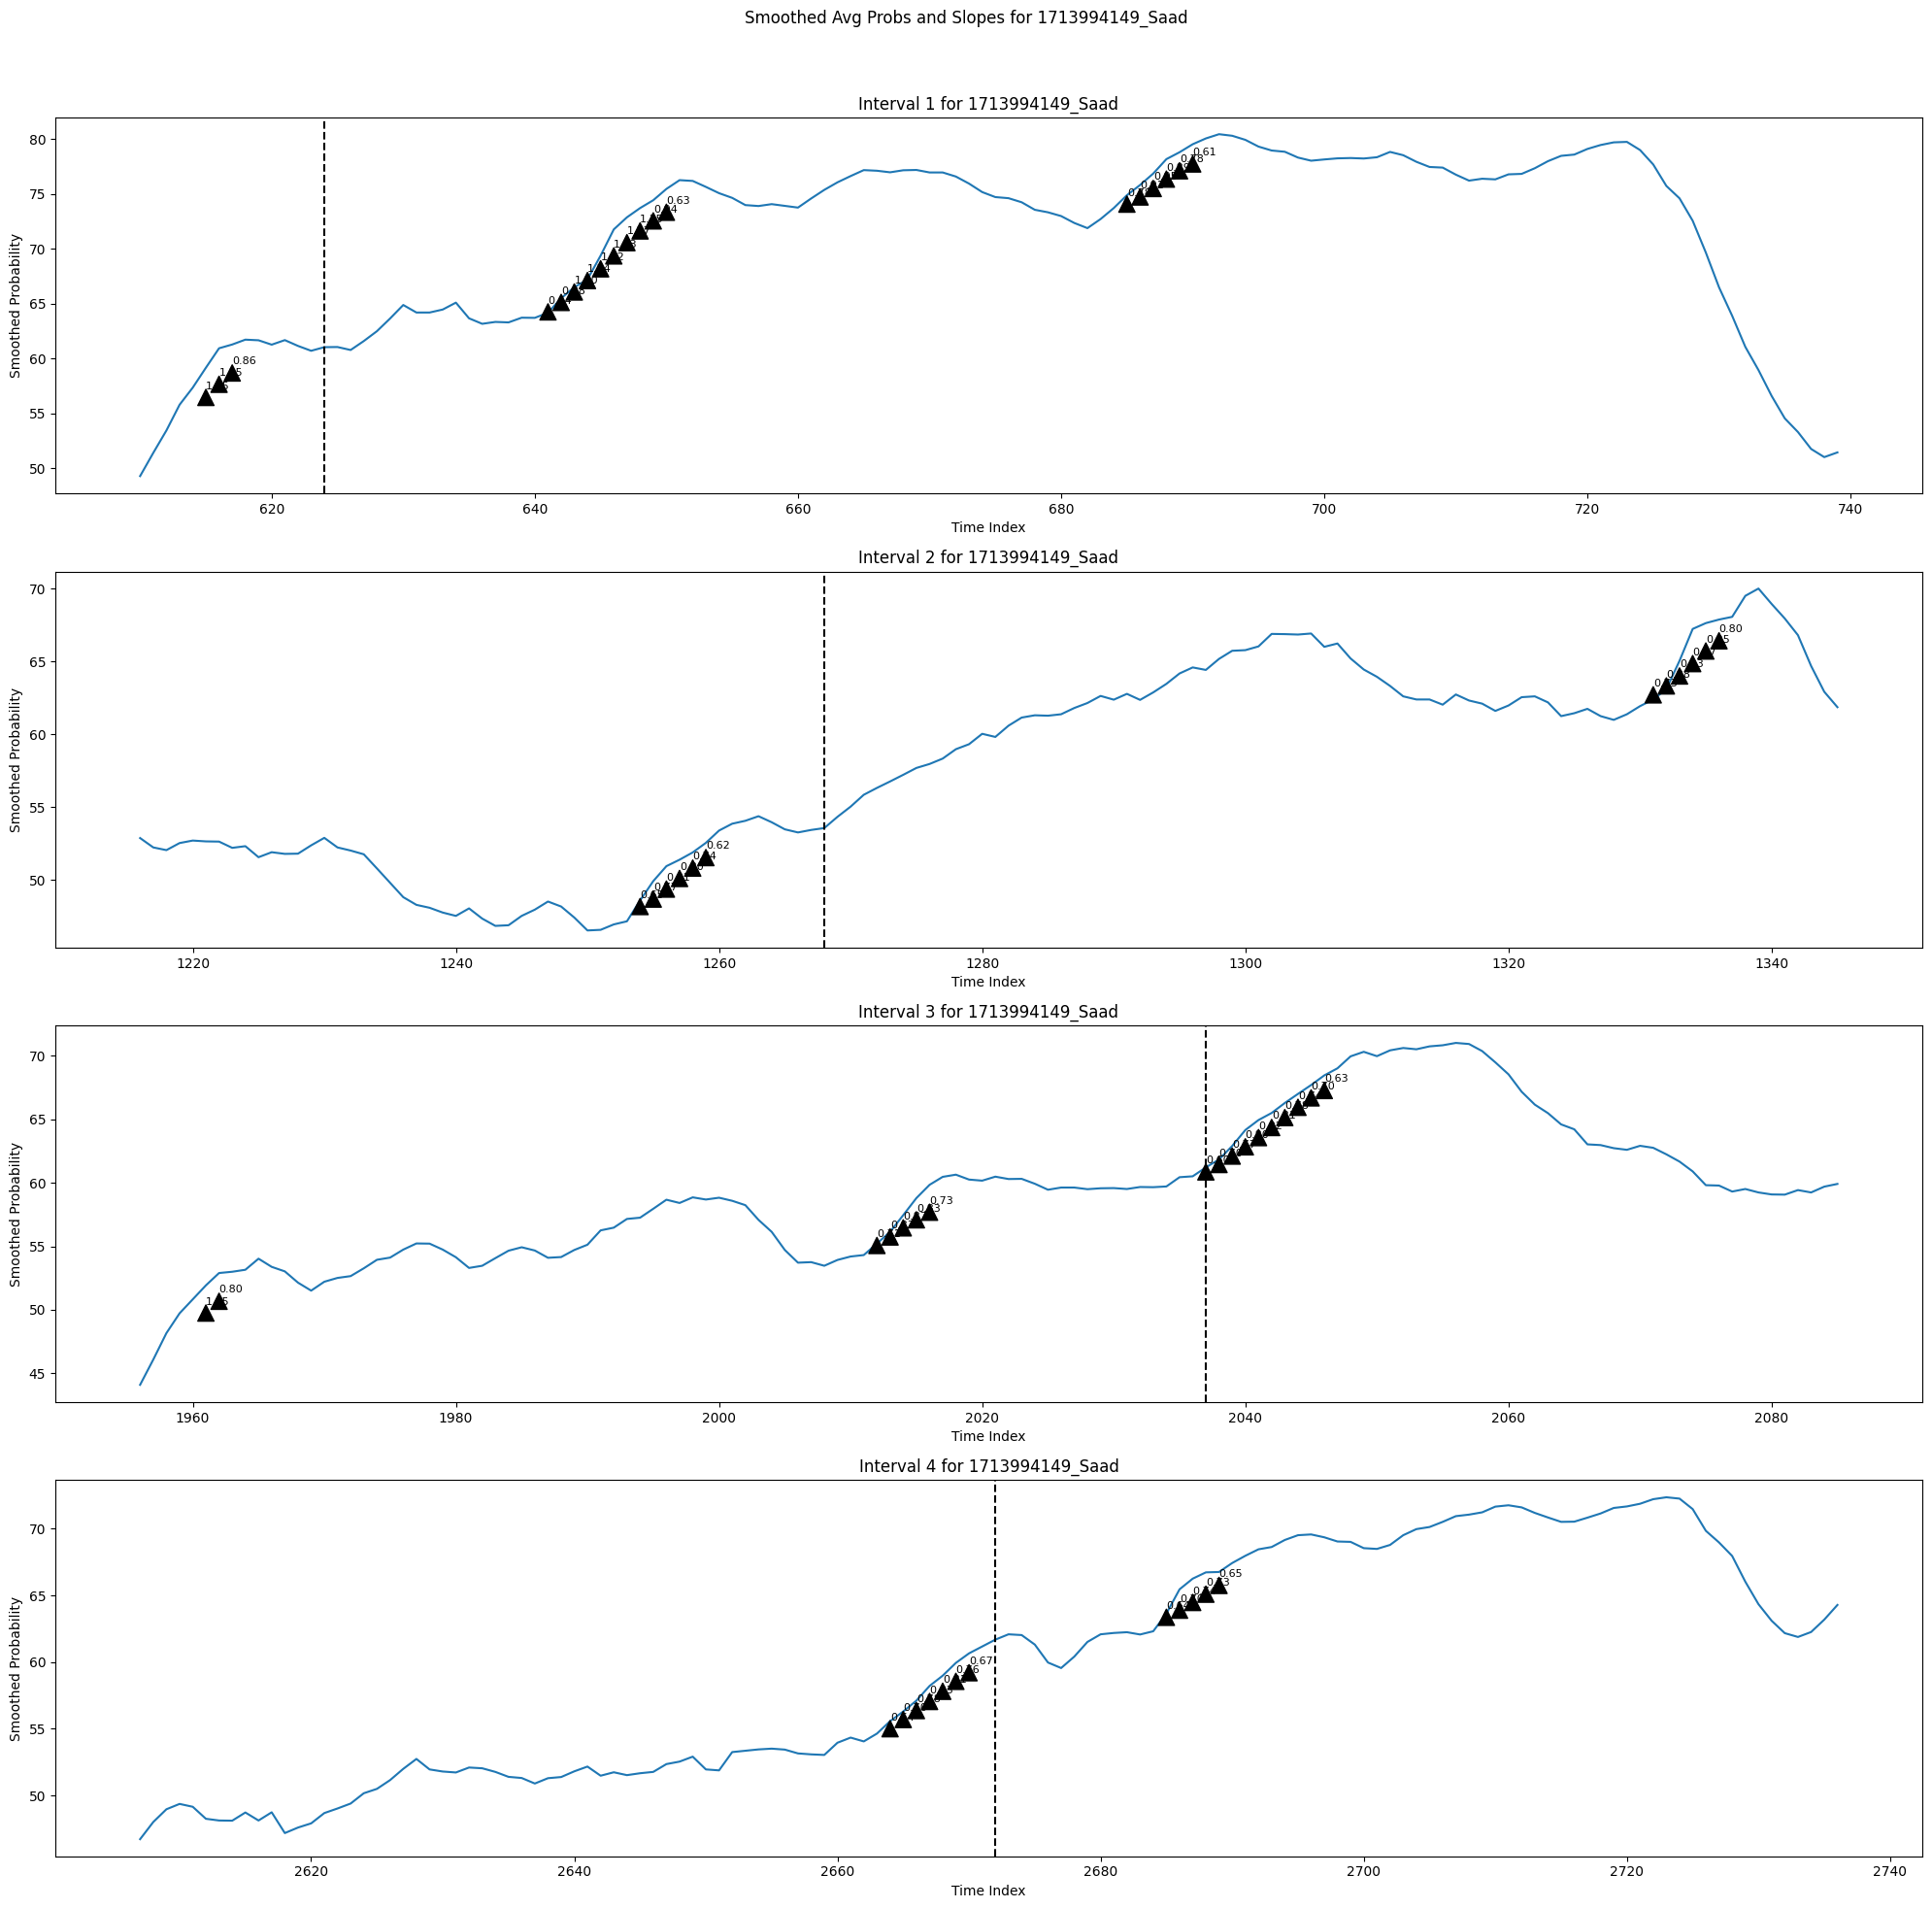

Process 1713458084_Andrei


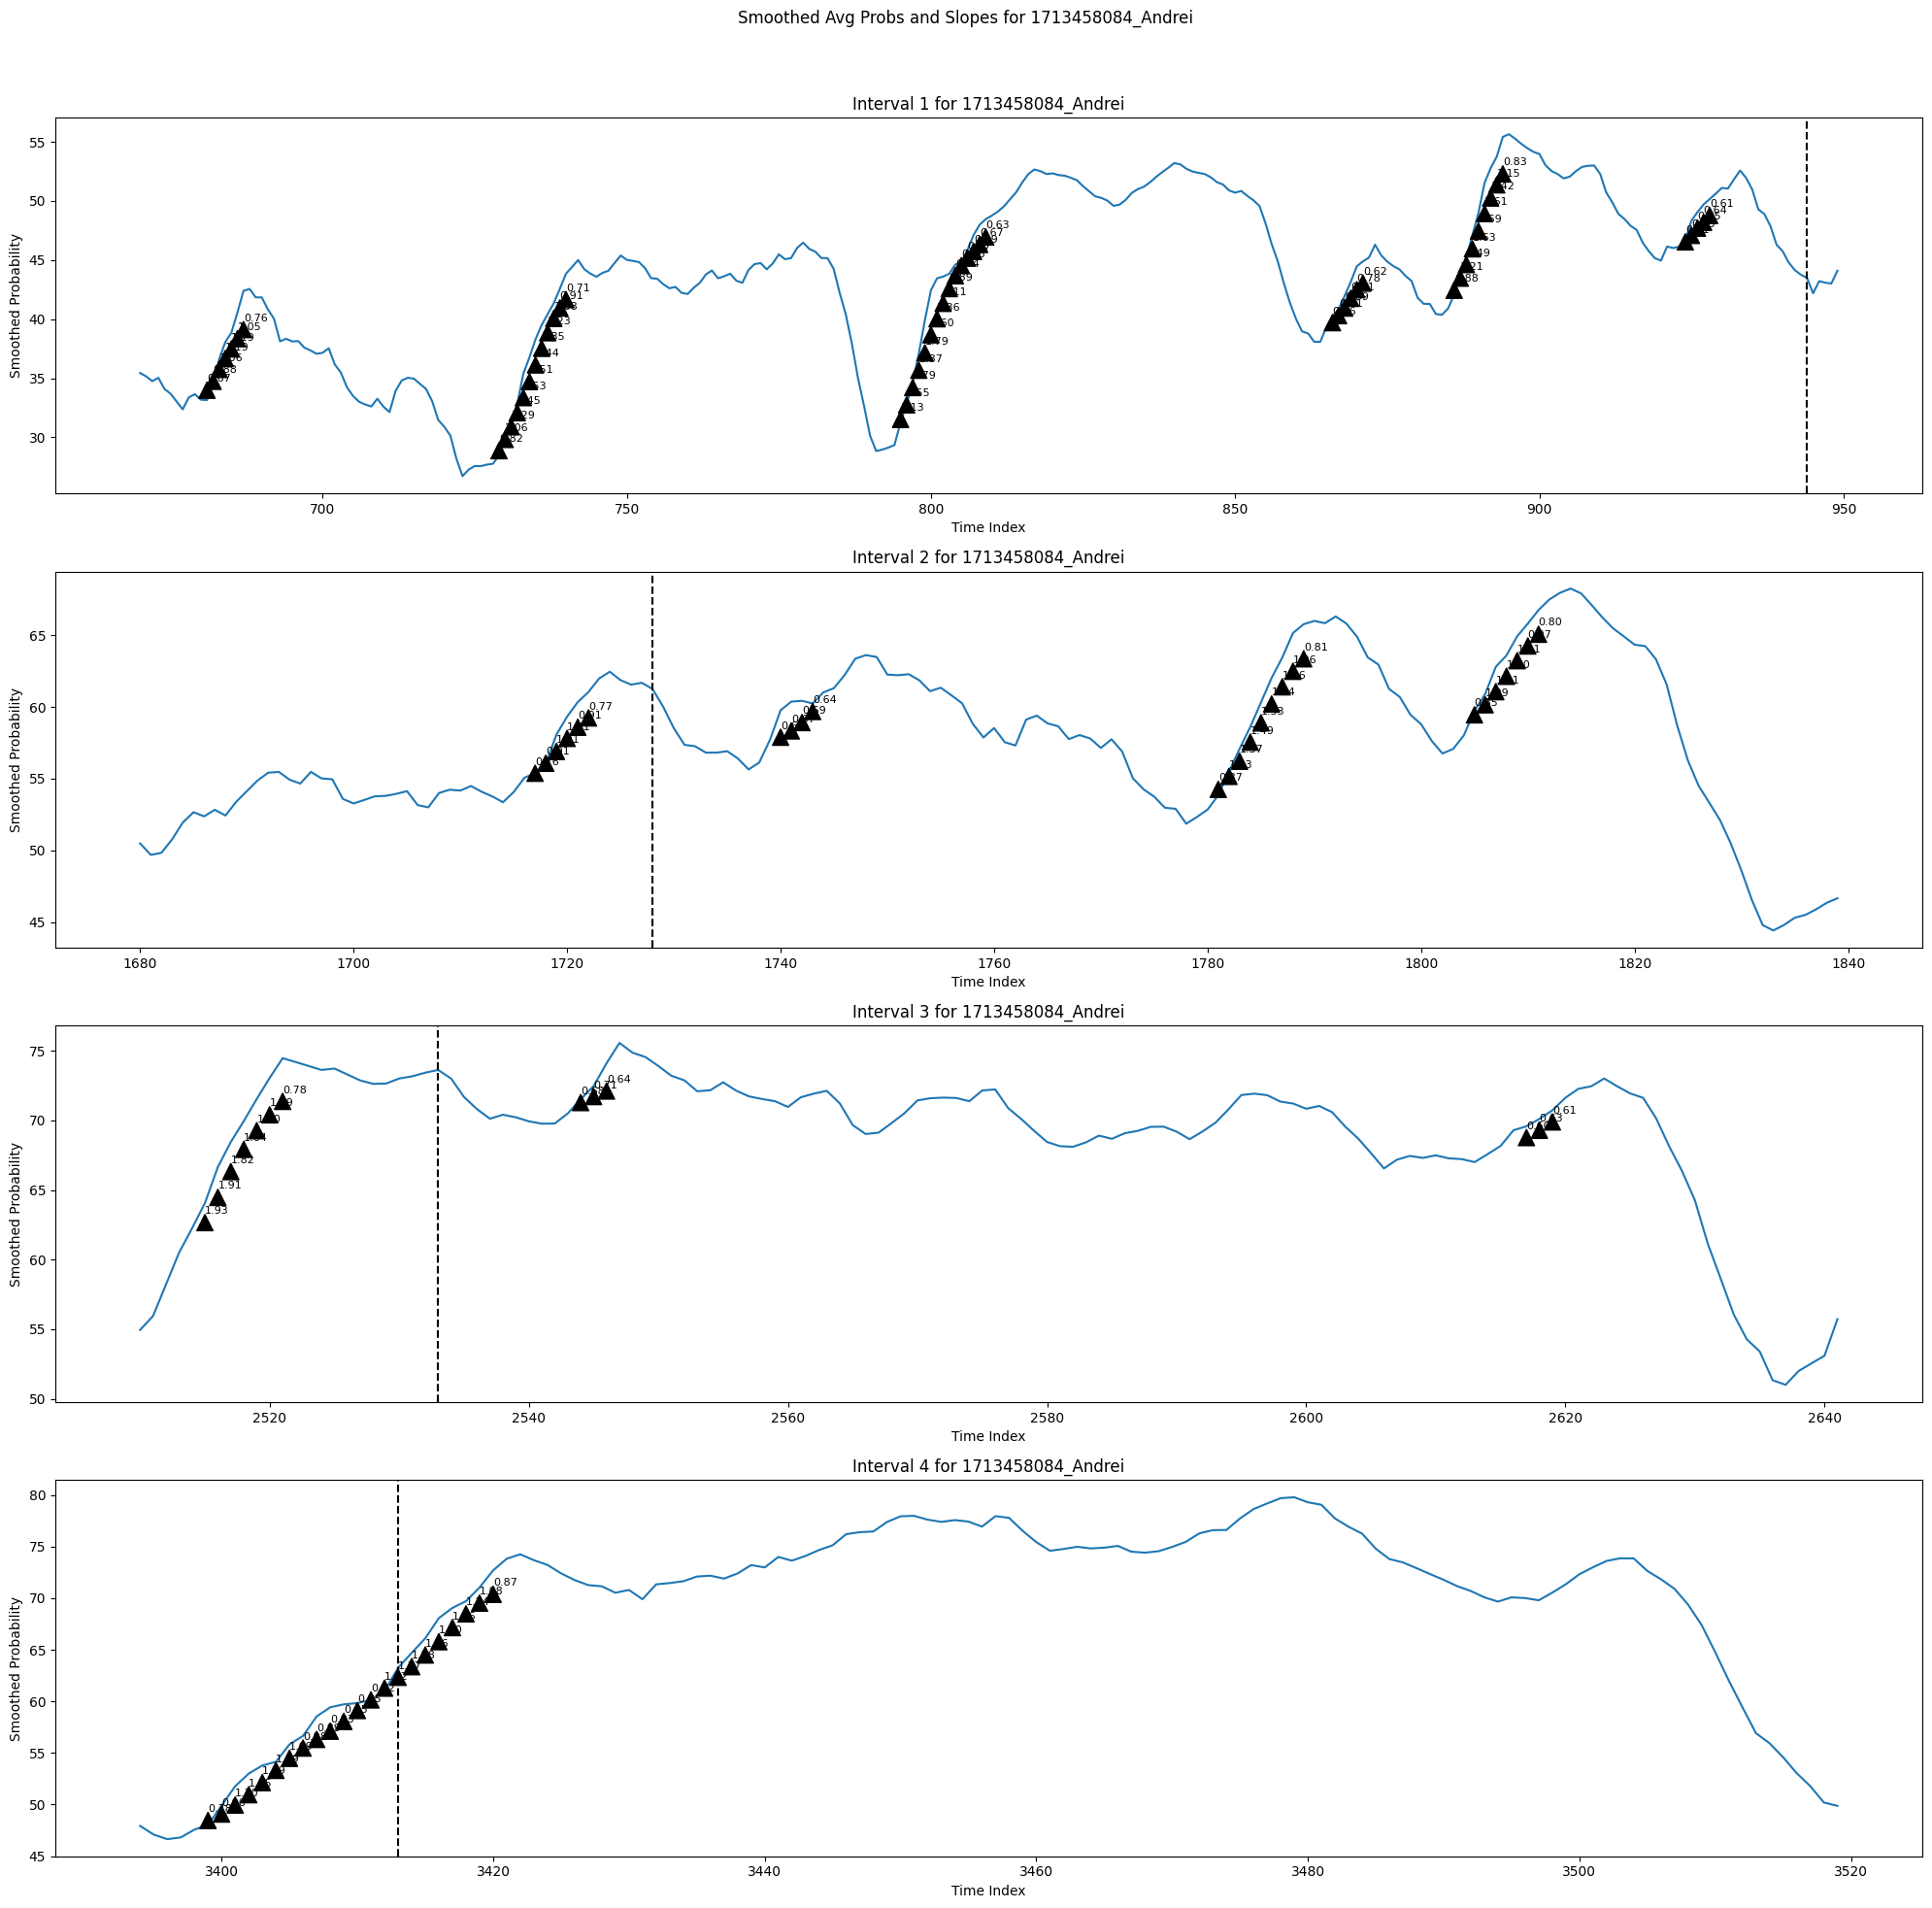

Process 1714511822_Nathan


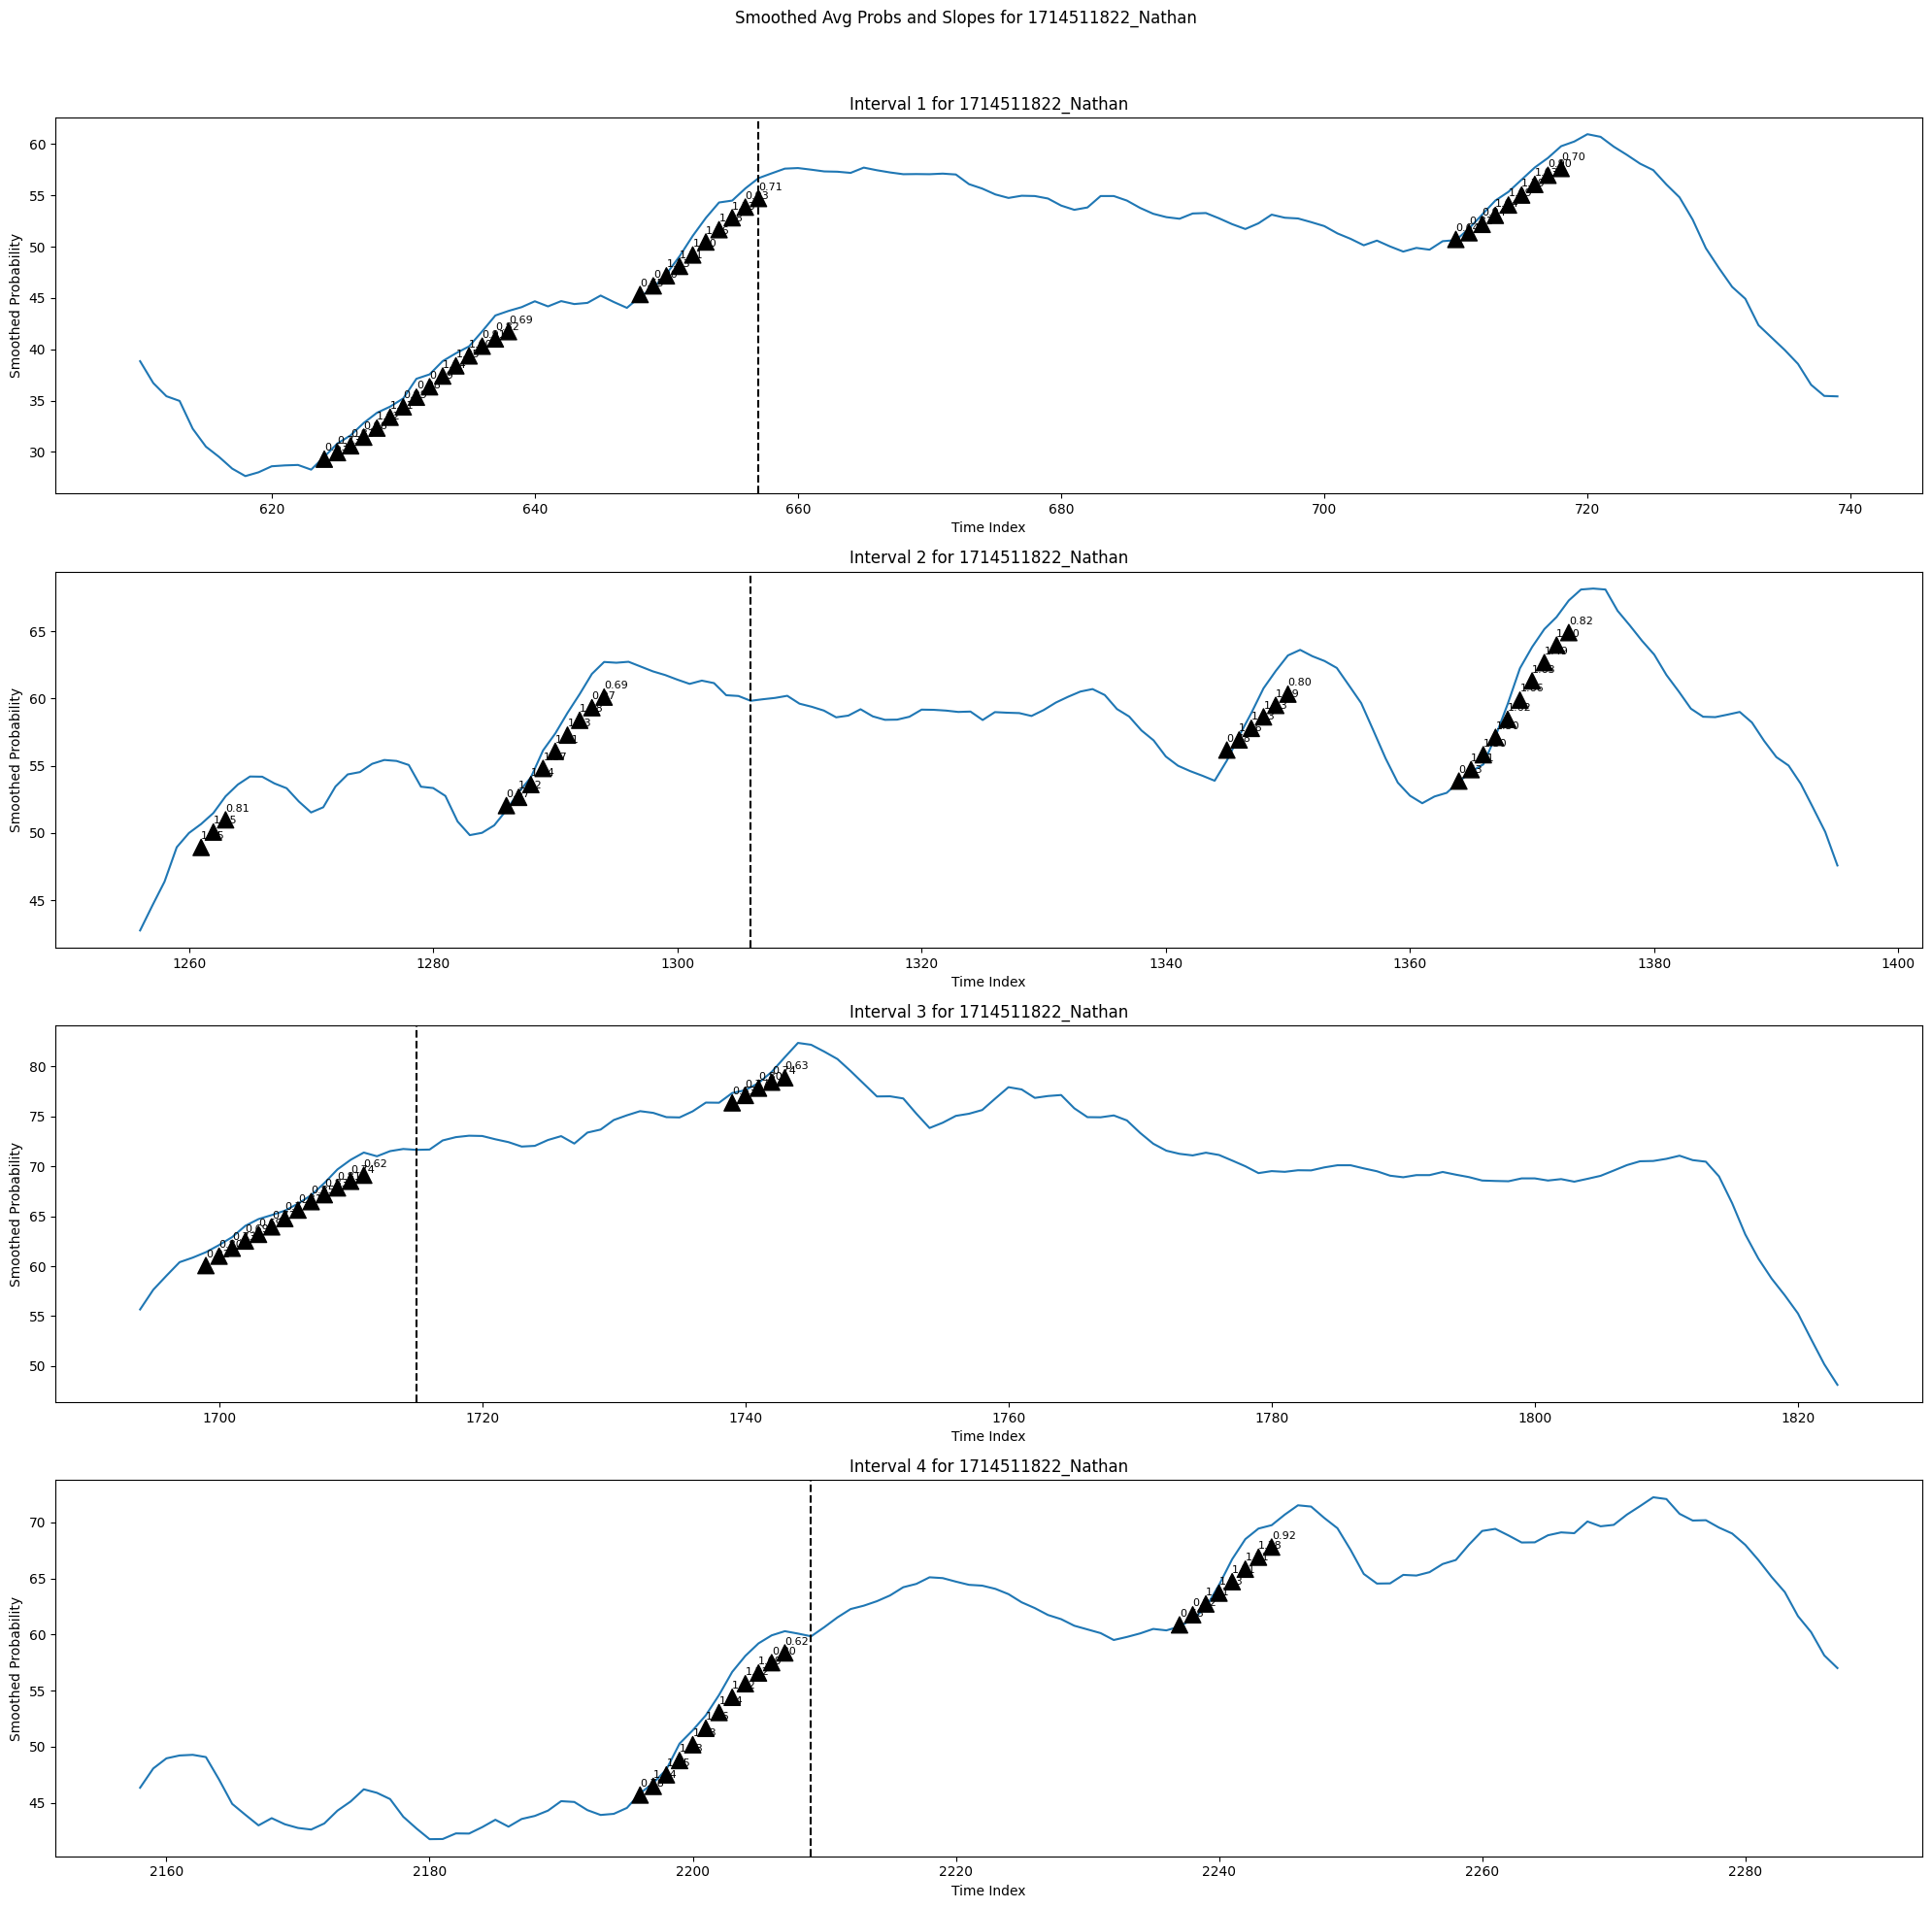

R2 Score: 0.5638126487249766
MAPE: 624682408046331.0


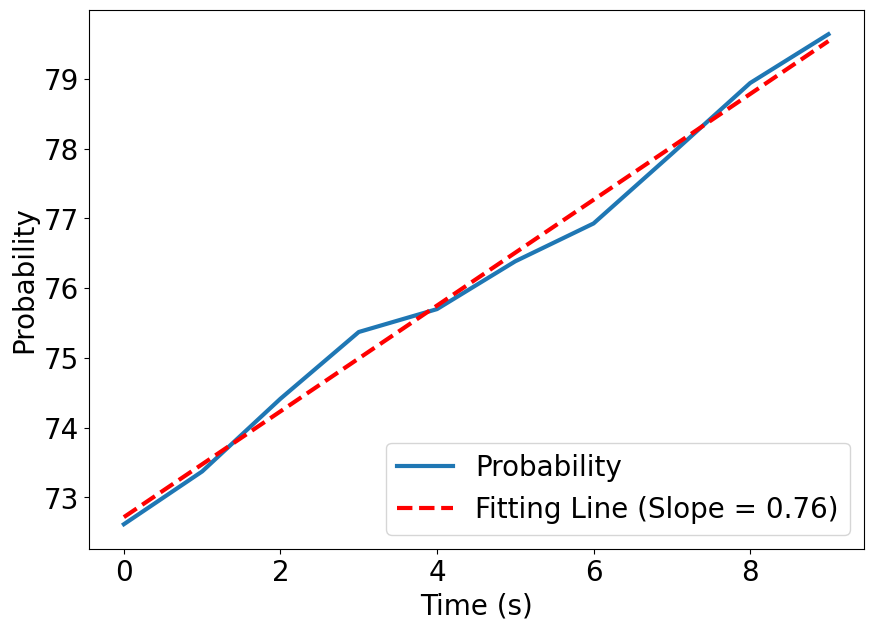

In [15]:
import random

window_size = 10
stride_size = 1
features_list = []

high_slope_windows = []  # List to store windows with slope > 0.4


for dir_name in dir_names:
    print(f'Process {dir_name}')
    # Get the dataset indices and smoothed average probabilities for the current subject
    dataset_indices = combined_metadata[combined_metadata['Dataset'] == dir_name].index
    avg_probs = final_probabilities[dataset_indices]
    
    # Apply smoothing if needed
    # smoothed_avg_probs = pd.Series(avg_probs).ewm(span=10).mean().to_numpy()*100
    # smoothed_avg_probs = pd.Series(avg_probs).rolling(window=window_size).mean().to_numpy() * 100
    smoothed_avg_probs = pd.Series(avg_probs).rolling(window=window_size).mean().dropna().to_numpy() * 100

    # Create a figure for each dir_name with 4 subplots
    fig, axs = plt.subplots(4, 1, figsize=(20, 20))
    fig.suptitle(f'Smoothed Avg Probs and Slopes for {dir_name}')

    # Process only head rotation intervals to detect true rising edges
    for i in range(1, 5):
        start_key = f'START{i}'
        end_key = f'END{i}'
        
        start_idx = int(stim[dir_name][start_key] / 250)
        end_idx = int(stim[dir_name][end_key] / 250)

        # Plot the smoothed average probabilities for the interval
        axs[i - 1].plot(range(start_idx, end_idx), smoothed_avg_probs[start_idx:end_idx], label='Smoothed Avg Probs')
        axs[i - 1].set_title(f'Interval {i} for {dir_name}')
        axs[i - 1].set_xlabel('Time Index')
        axs[i - 1].set_ylabel('Smoothed Probability')

        onset_key = f'ONSET{i}'
        if stim[dir_name][onset_key] is not None:
            onset_idx = int(stim[dir_name][onset_key] / 250)
            axs[i - 1].axvline(x=onset_idx, color='k', linestyle='--', label=f'Feedback')
        

        # Extract features within the head rotation interval
        for start in range(start_idx, end_idx - window_size + 1, stride_size):
            window = smoothed_avg_probs[start:start + window_size]
            x = np.arange(len(window)).reshape(-1, 1)
            
            # Fit linear regression to the window
            model = LinearRegression()
            model.fit(x, window)
            
            # Calculate features
            slope = model.coef_[0]  # Slope of the fitted line
            r2 = r2_score(window, model.predict(x))
            mape = mean_absolute_percentage_error(window, model.predict(x))
            mean_prob = np.mean(window)
            std_dev = np.std(window)
            cumulative_rise = window[-1] - window[0]  # Total rise over the window
            peak_prob = np.max(window)  # Maximum probability in the window
            
            # Determine if a significant rising trend is detected (tuned threshold)
            is_rising = slope > 0.05
            # print(slope)

            # slope_text = f'{slope:.2e}'
            if slope > 0.6:
                high_slope_windows.append((x, window, model.predict(x), slope, start, i - 1))  # Store predicted values as well
                axs[i - 1].annotate(f'{slope:.2f}', 
                                    xy=(start + window_size // 2, np.mean(window)),
                                    xytext=(start + window_size // 2, np.mean(window) + 0.02),
                                    arrowprops=dict(facecolor='black', shrink=0.05),
                                    fontsize=8)

            # Append features and label to the list
            features_list.append({
                'slope': slope,
                'r2': r2,
                'mape': mape,
                'mean_prob': mean_prob,
                'std_dev': std_dev,
                'cumulative_rise': cumulative_rise,
                'peak_prob': peak_prob,
                'is_rising': is_rising
            })

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Convert the list of dictionaries to a DataFrame
features_df = pd.DataFrame(features_list)

# Prepare data for training
X = features_df[['slope', 'r2', 'mape', 'mean_prob', 'std_dev', 'cumulative_rise', 'peak_prob']]
y = features_df['is_rising']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a regression or classification model
model = LinearRegression()  # or use a classifier like LogisticRegression if binary classification
model.fit(X_train, y_train)

# Evaluate model performance
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

# Choose one random window from the high_slope_windows if any
if high_slope_windows:
    selected_window = random.choice(high_slope_windows)
    x, window, predicted, slope, start, subplot_index = selected_window
    
    # Plot the fitting line on the selected window
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(x, window, linewidth=3, label='Probability')
    ax.plot(x, predicted, linewidth=3, color='red', linestyle='--', label=f'Fitting Line (Slope = {slope:.2f})')
    # ax.set_title(f'Random Selected Window with Slope > 0.4 in Interval {subplot_index + 1}')
    ax.set_xlabel('Time (s)', fontsize=20)
    ax.set_ylabel('Probability', fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower right', fontsize=20)
    
    plt.savefig(f'figures/LinearRegression.svg', format='svg', bbox_inches='tight')

## Check the entire data

No NaN values in smoothed results for 1712094934_Nhan
Detected a start window meeting both conditions for 1712094934_Nhan.
No NaN values in smoothed results for 1713985211_Mallory
Detected a start window meeting both conditions for 1713985211_Mallory.
No NaN values in smoothed results for 1713999445_Wil
Detected a start window meeting both conditions for 1713999445_Wil.
No NaN values in smoothed results for 1713293584_Jacob
Detected a start window meeting both conditions for 1713293584_Jacob.
No NaN values in smoothed results for 1713550894_AlexKagoda
Detected a start window meeting both conditions for 1713550894_AlexKagoda.
No NaN values in smoothed results for 1713820773_Andrew
Detected a start window meeting both conditions for 1713820773_Andrew.
No NaN values in smoothed results for 1713994149_Saad
Detected a start window meeting both conditions for 1713994149_Saad.
No NaN values in smoothed results for 1713458084_Andrei
Detected a start window meeting both conditions for 171345808

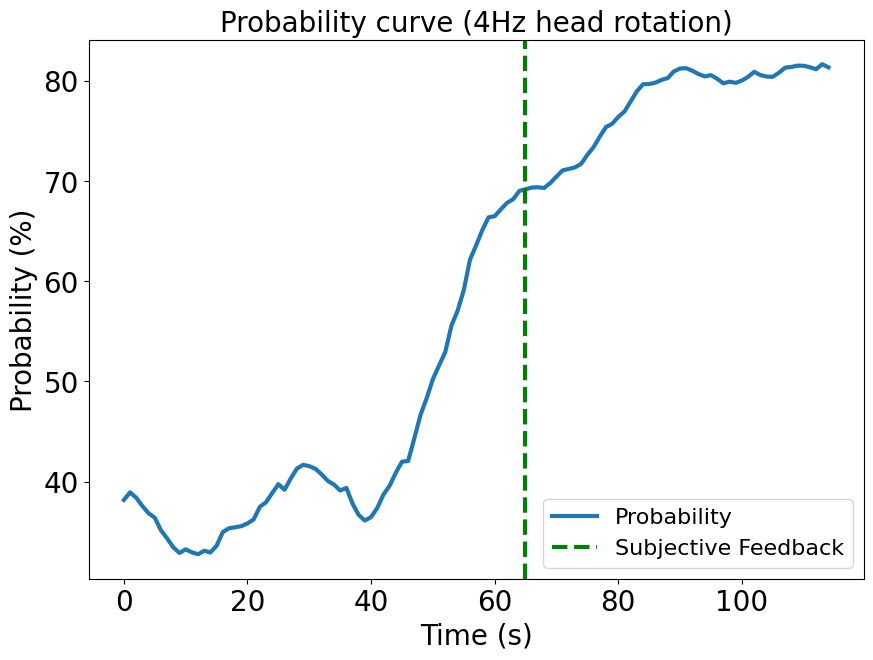

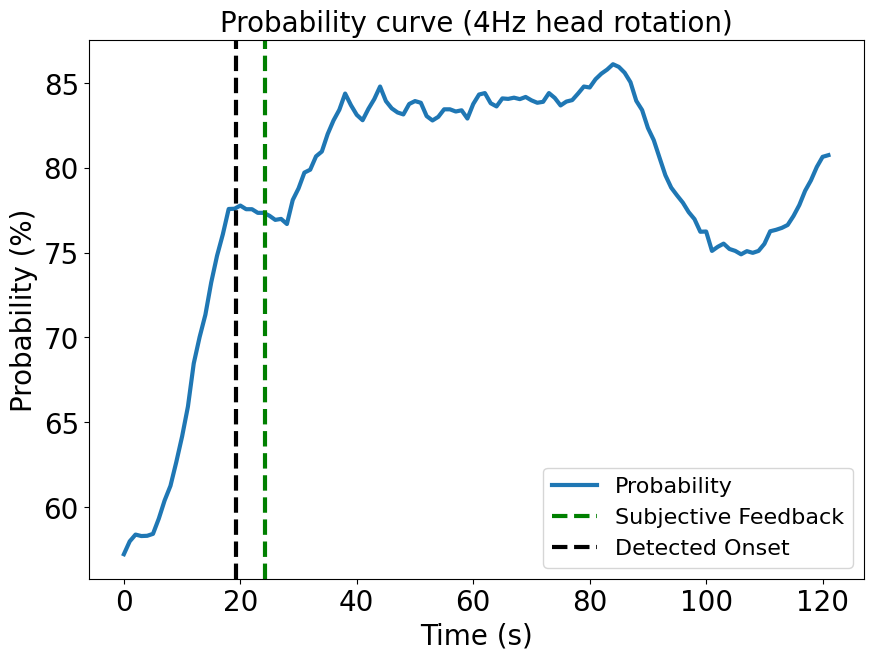

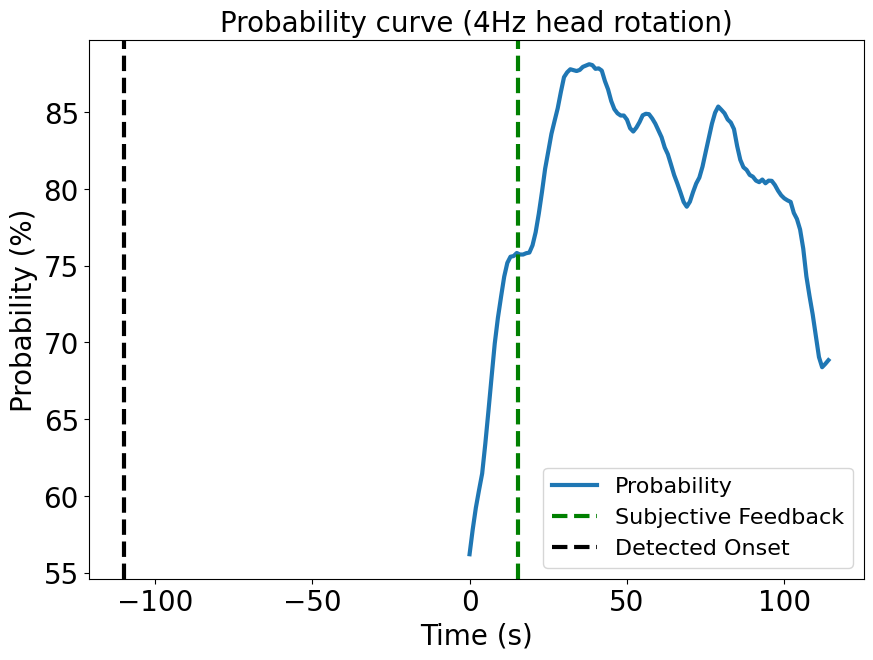

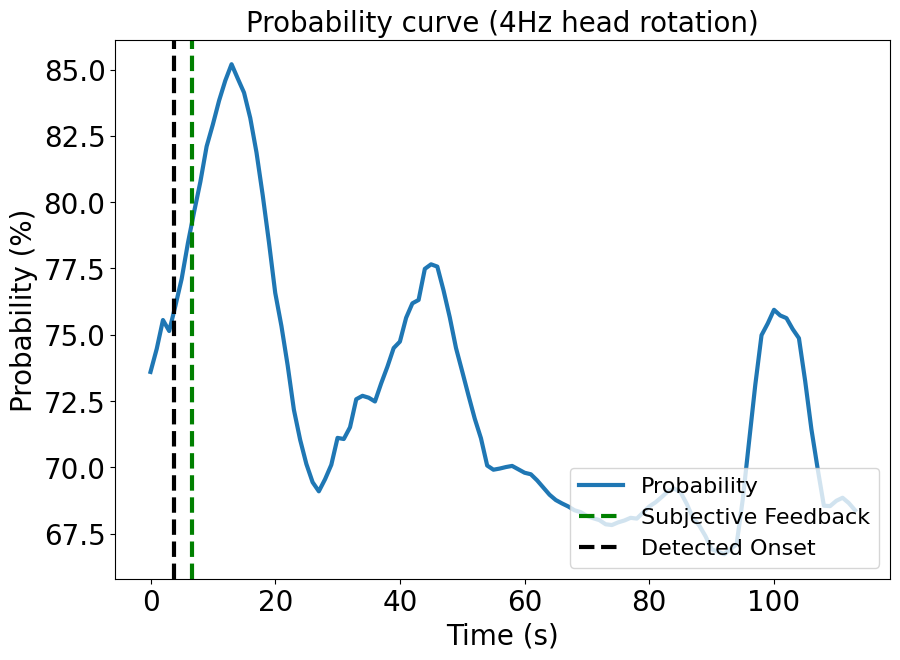

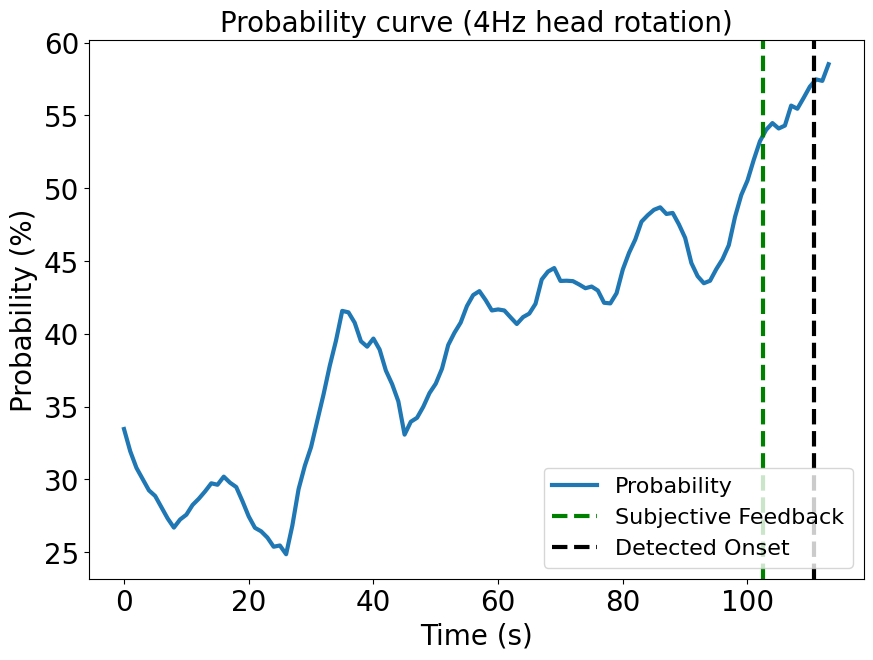

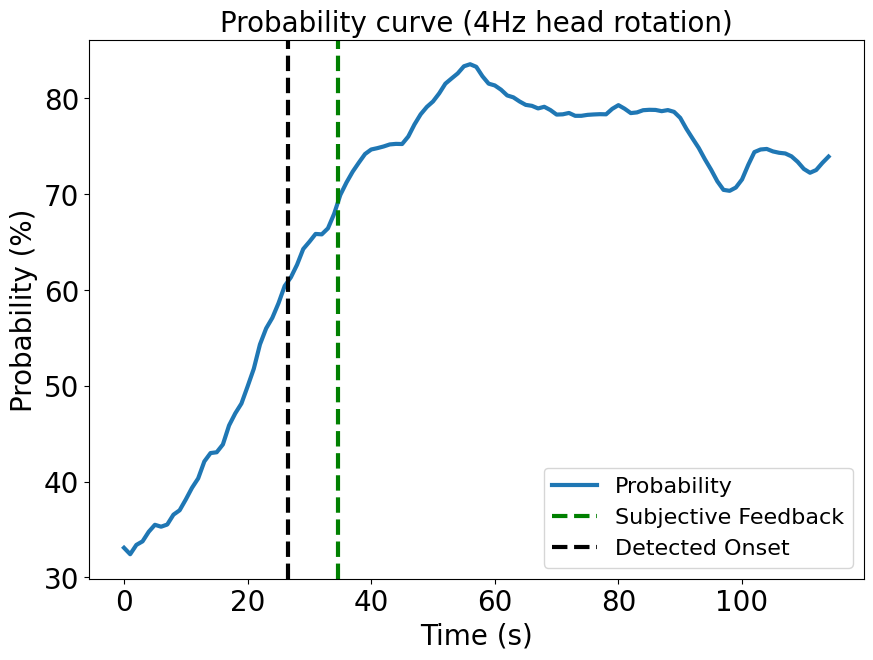

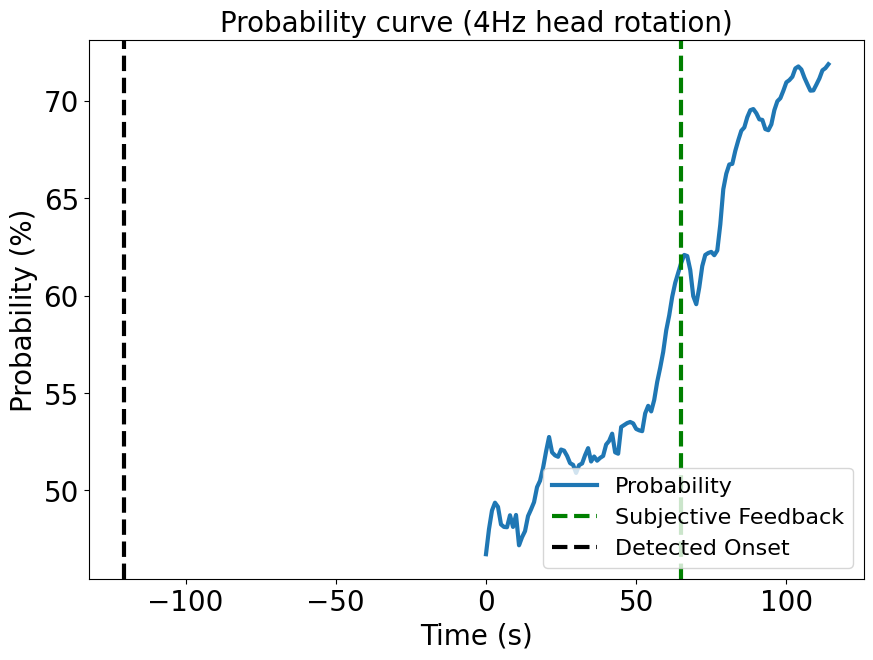

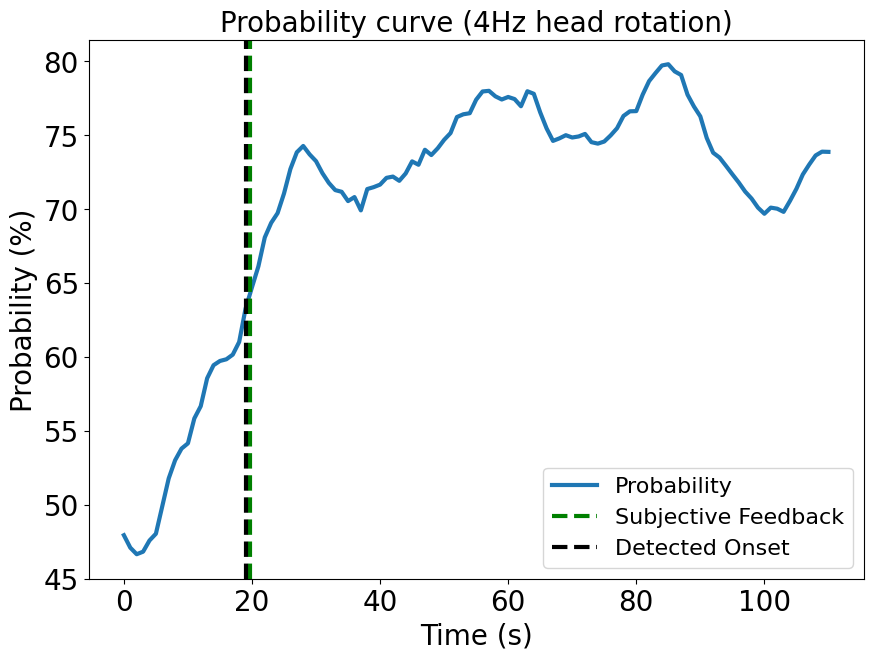

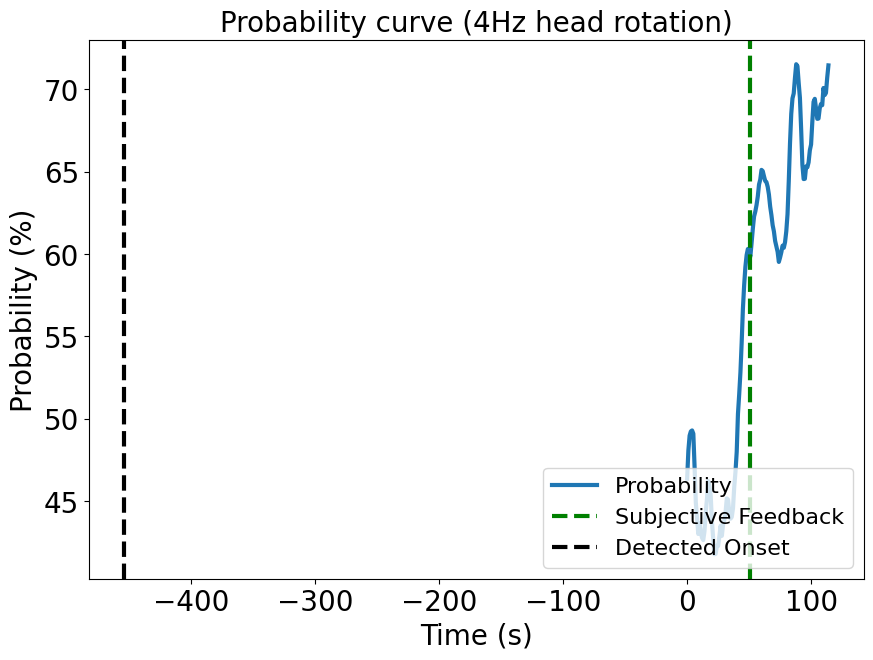

In [13]:
from collections import deque

# Adjustable parameters
consecutive_window = 10
slope_threshold = 0.5
probability_threshold = 50
true_detections = 0
false_detections = 0
missed_intervals = 0
required_consecutive_slopes = 10  # Updated requirement
baseline_window = 300
margin_factor = 1.07

ignore_window = 100

for dir_name in dir_names:
    # Get the dataset indices and smoothed average probabilities for the current subject
    dataset_indices = combined_metadata[combined_metadata['Dataset'] == dir_name].index
    avg_probs = final_probabilities[dataset_indices]
    
    # Apply smoothing if needed
    # smoothed_avg_probs = pd.Series(avg_probs).ewm(span=100).mean().to_numpy() * 100
    # smoothed_avg_probs = pd.Series(avg_probs).rolling(window=window_size).mean().fillna(0).to_numpy() * 100
    smoothed_avg_probs = pd.Series(avg_probs).rolling(window=window_size).mean().dropna().to_numpy() * 100

    if np.isnan(smoothed_avg_probs).any():
        print(f"NaN values detected in smoothed results for {dir_name}")
    else:
        print(f"No NaN values in smoothed results for {dir_name}")

    # Create a single plot for the entire smoothed_avg_probs
    # fig, ax = plt.subplots(figsize=(20, 5))
    plt.figure(figsize=(10, 7))

    plt.plot(smoothed_avg_probs[int(stim[dir_name]['START4']/250): int(stim[dir_name]['END4']/250) - 15], linewidth=3, label='Probability')

    # plt.axvline(x=stim[dir_name]['START1']/250, color='red', linestyle='--')
    # if stim[dir_name]['ONSET1'] is not None:
    #     plt.axvline(x=stim[dir_name]['ONSET1']/250, color='green', linestyle='--')
    # plt.axvline(x=stim[dir_name]['END1']/250, color='red', linestyle='--')
    
    # plt.axvline(x=stim[dir_name]['START2']/250, color='red', linestyle='--')
    # if stim[dir_name]['ONSET2'] is not None:
    #     plt.axvline(x=stim[dir_name]['ONSET2']/250, color='green', linestyle='--')
    # plt.axvline(x=stim[dir_name]['END2']/250, color='red', linestyle='--')
    
    # plt.axvline(x=stim[dir_name]['START3']/250, color='red', linestyle='--')
    # if stim[dir_name]['ONSET3'] is not None:
    #     plt.axvline(x=stim[dir_name]['ONSET3']/250, color='green', linestyle='--')
    # plt.axvline(x=stim[dir_name]['END3']/250, color='red', linestyle='--')
    
    # plt.axvline(x=stim[dir_name]['START4']/250, color='red', linestyle='--')
    # if stim[dir_name]['ONSET4'] is not None:
    #     plt.axvline(x=stim[dir_name]['ONSET4']/250, color='green', linestyle='--', label='Subjective Feedback')
    # plt.axvline(x=stim[dir_name]['END4']/250, color='red', linestyle='--', label='Head Rotation Interval')  

    plt.axvline(x=stim[dir_name]['ONSET4']/250-stim[dir_name]['START4']/250, color='green', linewidth=3, linestyle='--', label='Subjective Feedback')


    # ax.set_title(f'Smoothed Avg Probs for {dir_name}')
    # ax.set_xlabel('Time Index')
    # ax.set_ylabel('Probability')


    # Initialize variables to track the detection of conditions
    found_start_window = False
    potential_dizziness_start = None
    detections = []

    last_detection_index = -ignore_window  # Initialize to allow detection at the start
    idx = 0
    for start in range(0, len(smoothed_avg_probs) - consecutive_window + 1, 1):
        if start < last_detection_index + ignore_window:
            continue
        
        slopes = []
        probabilities = []
        consecutive_slopes_met = 0
        
        for i in range(consecutive_window):
            window = smoothed_avg_probs[start + i:start + i + window_size]
            x = np.arange(len(window)).reshape(-1, 1)

            # Fit linear regression to the window
            model = LinearRegression()
            model.fit(x, window)
            slope = model.coef_[0]
            slopes.append(slope)
            probabilities.append(np.mean(window))

            # Check if slope condition is met
            if slope >= slope_threshold:
                consecutive_slopes_met += 1
        
        if consecutive_slopes_met >= required_consecutive_slopes:
            if start >= baseline_window:
                process_baseline = smoothed_avg_probs[start - baseline_window:start]
            else:
                continue

            # process_baseline = pd.Series(process_baseline).ewm(span=20).mean().to_numpy()
            dynamic_baseline = np.mean(process_baseline)

            # Check if current probability is significantly higher than dynamic baseline
            # if np.mean(probabilities) > dynamic_baseline*margin_factor:
            if np.mean(probabilities) > dynamic_baseline*margin_factor and np.any(np.array(probabilities) > probability_threshold):
                found_start_window = True
                last_detection_index = start + consecutive_window  # Update the last detection index
                detections.append(start + 2*consecutive_window)
                idx +=1
                if idx == 4:
                    plt.axvline(x=start + 2*consecutive_window-stim[dir_name]['START4']/250, color='k', linewidth=3, linestyle='--', label='Detected Onset')
                # else:
                #     plt.axvline(x=start + 2*consecutive_window, color='k', linestyle='--')
                
    # Analyze the relationship between true detection, false detection and missed detection
    for detection in detections:
        is_true_detection = False
        for i in range(1, 5):
            if stim[dir_name][f'START{i}'] <= detection * 250 <= stim[dir_name][f'END{i}']:
                true_detections += 1
                is_true_detection = True
                break
        if not is_true_detection:
            false_detections += 1
    
    # Calculate missed intervals (false negatives)
    for i in range(1, 5):
        interval_detected = any(
            stim[dir_name][f'START{i}'] <= detection * 250 <= stim[dir_name][f'END{i}'] and stim[dir_name][f'ONSET{i}']
            for detection in detections
        )
        if not interval_detected:
            missed_intervals += 1


    if found_start_window:
        print(f"Detected a start window meeting both conditions for {dir_name}.")
    else:
        print(f"No start window meeting both conditions found for {dir_name}.")

    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    
    plt.title("Probability curve (4Hz head rotation)", fontsize=20)
    plt.xlabel("Time (s)",fontsize=20)
    plt.ylabel("Probability (%)",fontsize=20)
    # Set the font size for the x and y axis tick labels
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower right', fontsize=16)
    
    
    if 'Mallory' in dir_name:
        plt.savefig(f'figures/onset_detection_4Hz.svg', format='svg', bbox_inches='tight')
        
# Calculate Precision, Recall, and F1-Score
precision = true_detections / (true_detections + false_detections) if (true_detections + false_detections) > 0 else 0
recall = true_detections / (true_detections + missed_intervals) if (true_detections + missed_intervals) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


In [8]:
print(true_detections, false_detections, missed_intervals)

32 5 7
